In [1]:
"""
Two phase-transition experiment (Cowsik et al. 2024)
====================================================

* Reproduces Section 5 (Figure 7) & Appendix D on Food-101.
* Sweeps (alpha, sigma_w) grid, measures:
      – λ_a  (token angle exponent, Appendix A)
      – λ_g  (gradient exponent, log-ratio definition, Eq. 21)
      – final test loss after 15 epochs
"""

import copy, math, argparse, time, itertools, os, warnings
from pathlib import Path
import numpy as np
from tqdm import tqdm
import torch, torch.nn as nn, torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib as mpl


In [2]:
# ── deterministic seeding helper ───────────────────────────────────────────
def set_global_seed(seed: int):
    # random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # for full determinism (slows some ops):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
# ---------------------------------------------------------------------
# 0.  Food-101 dataloaders (128×128 → 16×16 patches)
# ---------------------------------------------------------------------
class CachedFood101(torch.utils.data.Dataset):
    def __init__(self, cache_file, device):
        obj = torch.load(cache_file, map_location=device)
        self.x, self.y = obj["images"], obj["labels"]     # plain tensors

    def __len__(self):             return len(self.y)
    def __getitem__(self, idx):    return self.x[idx], self.y[idx]
        

def food101_loaders(data_root, batch_size=256, need_download=False, num_workers=0):
    print(f"[data] Preparing Food-101 in {data_root} …", flush=True)
    # Start data 
    tfm = transforms.Compose([
        transforms.Resize(128),        # 128 on short side
        transforms.CenterCrop(128),    # enforce square crop
        transforms.ToTensor(),            # 0-1
        transforms.Lambda(lambda x: (x-0.5)*2)   # ℝ in [-1,1]
    ])
    train = torchvision.datasets.Food101(data_root, split='train', download=need_download, transform=tfm)
    test  = torchvision.datasets.Food101(data_root, split='test',  download=need_download, transform=tfm)
    
    # ── print dataset detail──────────────────────────────────────────────
    print(f"[data] ✓ train  {len(train):6d} images | "
          f"test {len(test):5d} images  · batch={batch_size} "
          f"({num_workers} workers)\n", flush=True)

    # ── cache dataset──────────────────────────────────────────────
    cache_train_path = data_root / "food101_128px_train.pt"
    if not cache_train_path.exists():
        xs_train = torch.zeros(len(train), 3, 128, 128, dtype=torch.float32)
        ys_train = torch.zeros(len(train), dtype=torch.int64)
        for i, (img, lab) in enumerate(tqdm(train, desc="preprocess")):
            xs_train[i] = img
            ys_train[i] = lab
        torch.save({"images": xs_train, "labels": ys_train}, cache_train_path)
        print("✓ saved", cache_train_path)
    else:
        print("✓ existed", cache_train_path)

    cache_test_path = data_root / "food101_128px_test.pt"
    if not cache_test_path.exists():
        xs_test = torch.zeros(len(test), 3, 128, 128, dtype=torch.float32)
        ys_test = torch.zeros(len(test), dtype=torch.int64)
        for i, (img, lab) in enumerate(tqdm(test, desc="preprocess")):
            xs_test[i] = img
            ys_test[i] = lab
        torch.save({"images": xs_test, "labels": ys_test}, cache_test_path)
        print("✓ saved", cache_test_path)
    else:
        print("✓ existed", cache_test_path)

    # ── cache dataset loader──────────────────────────────────────────────
    train_cache = CachedFood101(cache_train_path, device='cuda')  ####### Load full dataset to cuda for efficiency #######
    test_cache = CachedFood101(cache_test_path, device='cuda')    ####### Load full dataset to cuda for efficiency #######

    train_loader = DataLoader(
        train_cache, batch_size=batch_size, shuffle=True,
        num_workers=num_workers,    # 0 is fine (no JPEG decoding!)
        pin_memory=False
    )
    test_loader  = DataLoader(
        test_cache,  batch_size=256, shuffle=False,
        num_workers=0,
        pin_memory=False
    )

    return train_loader, test_loader


In [4]:
# ---------------------------------------------------------------------
# 1.  Patch-to-token stem  (16×16 patches ⇒ 64-dim token)
# ---------------------------------------------------------------------
class PatchStem(nn.Module):
    def __init__(self, d=64, patch=16):
        super().__init__()
        self.conv = nn.Conv2d(3, d, kernel_size=patch, stride=patch)

    def forward(self, x):                      # (B,3,128,128)
        x = self.conv(x)                       # (B,d,8,8)
        return x.flatten(2).transpose(1,2)     # (B,64, d)


In [5]:
# ---------------------------------------------------------------------
# 2.  One-head transformer layer  (d = 64)
# ---------------------------------------------------------------------
class OneHeadLayer(nn.Module):
    def __init__(self, d, sigma_A, sigma_w, alpha):
        super().__init__()
        self.d = d
        self.alpha = alpha
        self.alphatilde = math.sqrt(max(1-alpha**2, 0.0))

        inv = 1.0 / math.sqrt(d)
        self.Q = nn.Parameter(torch.randn(d,d)*inv)
        self.K = nn.Parameter(torch.randn(d,d)*inv*sigma_A)
        self.V = nn.Parameter(torch.randn(d,d)*inv)
        self.W0 = nn.Parameter(torch.randn(d,d)*inv*sigma_w)
        self.W1 = nn.Parameter(torch.randn(d,d)*inv*sigma_w)

    @staticmethod
    def norm(x):
        return x / (torch.linalg.vector_norm(x, dim=-1, keepdim=True)+1e-9) * math.sqrt(x.shape[-1])

    def forward(self, x):
        # attention layer with pre-layernorm
        y = self.norm(x)
        A = torch.softmax((y@self.Q)@(y@self.K).transpose(-2,-1)/math.sqrt(self.d), dim=-1)
        x = self.alphatilde*x + self.alpha*(A@(y@self.V))

        # mlp
        y = self.norm(x)
        h = torch.tanh(y@self.W0)
        out = torch.tanh(h@self.W1)
        return self.alphatilde*x + self.alpha*out


In [6]:
# ---------------------------------------------------------------------
# 3.  ViT-tiny backbone + classifier
# ---------------------------------------------------------------------
class TinyViT(nn.Module):
    def __init__(self, L, d, sigma_A, sigma_w, alpha, n_cls=101):
        super().__init__()
        self.stem = PatchStem(d)
        # CLS token + position embeds
        self.cls = nn.Parameter(torch.zeros(1,1,d))
        self.pe  = nn.Parameter(torch.randn(1,65,d)/math.sqrt(d))

        self.layers = nn.ModuleList([
            OneHeadLayer(d, sigma_A, sigma_w, alpha) for _ in range(L)
        ])
        self.head = nn.Linear(d, n_cls)

    def forward(self, img):
        tok = self.stem(img)              # (B,64,d)
        cls = self.cls.repeat(img.size(0), 1, 1)      # same initial CLS token at input (zero vector)
        x = torch.cat([cls, tok], dim=1) + self.pe
        for layer in self.layers:
            x = layer(x)
        return self.head(x[:,0])


In [7]:
# ---------------------------------------------------------------------
# 4.  λ_a (1-layer, Appendix A)  &  λ_g (log-ratio, 16-layers)
# ---------------------------------------------------------------------
@torch.no_grad()
def sample_correlated_tokens(d: int,
                             n_tokens: int,
                             cos_init: float = .99,
                             dtype: torch.dtype = torch.float64, 
                             device: str = "cuda") -> torch.Tensor:
    """
    Returns an (n, d) tensor whose rows X_i satisfy
        E[X_i·X_i]       = d
        E[X_i·X_j]       = cos_theta * d    (i≠j)
        Cov((X_i)_a,(X_j)_b) = 0 for a≠b, ∀ i,j

    Construction
    ------------
    For each coordinate k=1…d draw a *shared* latent g_k ~ N(0,1).
    For each token i draw an independent η_{ik} ~ N(0,1).
        X_{ik} = √cos_theta · g_k + √(1−cos_theta) · η_{ik}.
    Coordinates are independent because g_k and η_{ik} vary with k.
    """
    g   = torch.randn(d,           dtype=dtype, device=device)                      # shared across tokens
    eta = torch.randn(n_tokens, d, dtype=dtype, device=device)                      # independent noise
    x   = math.sqrt(cos_init) * g + math.sqrt(1. - cos_init) * eta   # broadcast add
    return x        # no layer-norm ⇒ coordinate-wise independence preserved


@torch.no_grad()
def estimate_lambda_a(model,
                      d: int = 64,
                      n_tokens: int = 256,
                      cos_init: float = .99,
                      device: str = "cuda") -> float:
    """
    Estimate λ_a using *exactly the current weights* of ``model``.

    Parameters
    ----------
    model         : TinyViT or any nn.Module with `.layers` attribute
    d             : token dimension (same as model.d)
    n_tokens      : number of tokens to probe
    cos0          : initial token–token cosine (≈ 0.99 in the paper)
    device        : match model's device

    Returns
    -------
    lambda_a (float)
    """
    # build a lightweight float64 *view* of the model
    model_fp64 = copy.deepcopy(model).to(dtype=torch.float64, device=device)
    model_fp64.eval()
    
    ####### TO DO: use fewer layers to make the computation stable ########
    # --- multi-layer slope ----------------------------------------
    lambda_a_lst = []
    for layer in model_fp64.layers:
        # generate input test tokens for each layer
        x0 = sample_correlated_tokens(d=d, n_tokens=n_tokens, cos_init=cos_init, 
                                  dtype=torch.float64, device=device).unsqueeze(0)
        
        # pass through the layer
        x1 = x0
        x1 = layer(x1)
        
        # compute inner products   (include i=j terms exactly as the authors do)
        cos0 = (x0.squeeze() @ x0.squeeze().T)
        cos1 = (x1.squeeze() @ x1.squeeze().T)

        eye_mask = torch.eye(n_tokens, dtype=torch.bool, device=x0.device)
        # compute average inner products
        q       = cos0[eye_mask].mean().item()      # ⟨diag(cos0)⟩
        q_prime = cos1[eye_mask].mean().item()      # ⟨diag(cos1)⟩
        p       = cos0[~eye_mask].mean().item()     # ⟨off-diag(cos0)⟩
        p_prime = cos1[~eye_mask].mean().item()     # ⟨off-diag(cos1)⟩
    
        lambda_a_lst.append(math.log((1.0 - p_prime/q_prime) / (1.0 - p/q)))
    return np.mean(lambda_a_lst)

def estimate_lambda_g(model, 
                      d: int = 64, 
                      n_tokens: int = 256,
                      cos_init: float = .99,
                      device: str = "cuda") -> float:
    
    # build a lightweight float64 *view* of the model
    model_fp64 = copy.deepcopy(model).to(dtype=torch.float64, device=device)
    model_fp64.eval()
    
    x0 = sample_correlated_tokens(d=d, n_tokens=n_tokens, cos_init=cos_init, 
                                  dtype=torch.float64, device=device).unsqueeze(0)   # (1,n,d)
    x0.requires_grad_(True)
    
    x = x0
    for layer in model_fp64.layers:
        x = layer(x)
    R = torch.randn_like(x)
    s = (x*R).sum()
    grad = torch.autograd.grad(s, x0)[0]
    
    num = torch.sum(grad**2)
    denom = torch.sum(R**2)
    return math.log((num/denom).item()) / len(model.layers)


In [8]:
@torch.no_grad()
def evaluate_topk(model, loader, device, k=(1, 5)):
    """
    Returns a dict  {'top1': err1, 'top5': err5, 'loss': avg_ce_loss}
    where err1 / err5 are *error* rates (1 − accuracy).
    """
    total   = 0
    correct_top1 = 0
    correct_top5 = 0
    loss_sum = 0.0

    model.eval()
    for xb, yb in loader:
        # the whole dataset has already been loaded on cuda
        # xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True) 
        logits = model(xb)

        # cross-entropy for avg test loss
        loss_sum += F.cross_entropy(logits, yb, reduction='sum').item()

        # top-k
        maxk = max(k)
        _, pred_topk = logits.topk(maxk, dim=1)       # (B, maxk)
        pred_topk = pred_topk.t()                     # (maxk, B)
        correct_matrix = pred_topk.eq(yb.view(1, -1).expand_as(pred_topk))

        correct_top1 += correct_matrix[:1].sum().item()
        correct_top5 += correct_matrix[:5].sum().item()
        total        += yb.size(0)

    top1_err = 1.0 - correct_top1 / total
    top5_err = 1.0 - correct_top5 / total
    avg_loss = loss_sum / total
    return {'top1': top1_err, 'top5': top5_err, 'loss': avg_loss}

In [9]:
# ---------------------------------------------------------------------
# 5.  Train-and-evaluate routine (15 epochs, Adam, lr 3e-4)
# ---------------------------------------------------------------------
def train_eval(model, loaders, alpha, sigma_w, epochs=15, 
               device='cuda', save_dir="models"):
    
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    train_loader, test_loader = loaders
    opt = torch.optim.Adam(model.parameters(), lr=3e-4)

    # ----- validation accuracy and loss (initialization) -----
    metrics_init = evaluate_topk(model, test_loader, device)

    # ----- training -----
    print(f"[σ_w={sigma_w:4.2f}, α={alpha:4.2f}] training start!", flush=True)
    for epoch in tqdm(range(epochs)):
        model.train()
        for xb, yb in train_loader:
            opt.zero_grad()
            loss = F.cross_entropy(model(xb), yb)
            loss.backward()
            opt.step()

    # ----- validation accuracy and loss -----
    metrics = evaluate_topk(model, test_loader, device)

    # ─── checkpoint ─────────────────────────────────────────────────
    ckpt_path = (Path(save_dir) /
                 f"alpha_{alpha:.3f}_sigmaw_{sigma_w:.3f}_top5{metrics['top5']:.3f}.pt")
    torch.save({
        "model_state": model.state_dict(),
        "alpha": alpha,
        "sigma_w": sigma_w,
        "epoch": epochs,
        "metrics": metrics,
        "metrics_init": metrics_init,
    }, ckpt_path)
    print(f"    [save] → {ckpt_path}", flush=True)

    return metrics, metrics_init


In [10]:
# ---------------------------------------------------------------------
# 6.  Grid sweep   (α, σ_w)
# ---------------------------------------------------------------------
seed = 2025
n_init = 1             # number of independent trials for each hyperparameters
L = 16                 # depth of NN
d = 64                 # token dimension
sigma_A = 1.0          # Q,K,V std variance

set_global_seed(seed)

device = torch.device('cuda')
train_loader, test_loader = food101_loaders(Path('data/').expanduser(),
                                            batch_size=256, num_workers=0)
alphas  = np.linspace(0.05, 0.95, 20)
sigmasw = np.linspace(0.2, 4.0, 20)

lambda_a_grid = np.zeros((len(sigmasw), len(alphas)))
lambda_g_grid = np.zeros_like(lambda_a_grid)
top1_grid    = np.zeros_like(lambda_a_grid)
top5_grid    = np.zeros_like(lambda_a_grid)
loss_grid    = np.zeros_like(lambda_a_grid)
top1_init_grid    = np.zeros_like(lambda_a_grid)
top5_init_grid    = np.zeros_like(lambda_a_grid)
loss_init_grid    = np.zeros_like(lambda_a_grid)

for i, sw in enumerate(sigmasw):
    for j, a in enumerate(alphas):
        lambda_a_lst, lambda_g_lst = [], []
        top1_lst, top5_lst, loss_lst = [], [], []
        top1_init_lst, top5_init_lst, loss_init_lst = [], [], []
        for _ in range(n_init):
            # initalize full network
            net = TinyViT(L=L, d=d, sigma_A=sigma_A, sigma_w=sw, alpha=a).to(device)
            # compute λ_a & λ_g at initialization
            lambda_a_lst.append(estimate_lambda_a(net, d=64, n_tokens=256, cos_init=.99, device=device))
            lambda_g_lst.append(estimate_lambda_g(net, d=64, n_tokens=256, cos_init=.99, device=device))
            # training
            metrics, metrics_init = train_eval(model=net, loaders=(train_loader,test_loader), 
                                               device=device, epochs=15,
                                               alpha=a, sigma_w=sw, save_dir="models")
            top1_lst.append(metrics['top1'])
            top5_lst.append(metrics['top5'])
            loss_lst.append(metrics['loss'])
            top1_init_lst.append(metrics_init['top1'])
            top5_init_lst.append(metrics_init['top5'])
            loss_init_lst.append(metrics_init['loss'])
            
            torch.cuda.empty_cache()
            
        lambda_a_grid[i,j] = np.mean(lambda_a_lst)
        lambda_g_grid[i,j] = np.mean(lambda_g_lst)
        top1_init_grid[i,j]      = np.mean(top1_init_lst)
        top5_init_grid[i,j]      = np.mean(top5_init_lst)
        loss_init_grid[i,j]     = np.mean(loss_init_lst)
        top1_grid[i,j]      = np.mean(top1_lst)
        top5_grid[i,j]      = np.mean(top5_lst)
        loss_grid[i,j]     = np.mean(loss_lst)

        # quick feedback
        print(f"    [λ] λ_a={lambda_a_grid[i,j]:+2.5e}, λ_g={lambda_g_grid[i,j]:+2.5e}, ", flush=True)
        print(f"    [test init] test init top1={top1_init_grid[i,j]:4.2%}, test init top5={top5_init_grid[i,j]:4.2%}, test init loss={loss_init_grid[i,j]:5.3f}", flush=True)
        print(f"    [test] test top1={top1_grid[i,j]:4.2%}, test top5={top5_grid[i,j]:4.2%}, test loss={loss_grid[i,j]:5.3f}", flush=True)


dir_path = Path("grid/")
dir_path.mkdir(parents=True, exist_ok=True)
np.savez('grid/lambda_a_grid.npz', alphas=alphas, sigmasw=sigmasw, data=lambda_a_grid)
np.savez('grid/lambda_g_grid.npz', alphas=alphas, sigmasw=sigmasw, data=lambda_g_grid)
np.savez('grid/testtop1_init_grid.npz',  alphas=alphas, sigmasw=sigmasw, data=top1_init_grid)
np.savez('grid/testtop5_init_grid.npz',  alphas=alphas, sigmasw=sigmasw, data=top5_init_grid)
np.savez('grid/testloss_init_grid.npz',  alphas=alphas, sigmasw=sigmasw, data=loss_init_grid)
np.savez('grid/testtop1_grid.npz',  alphas=alphas, sigmasw=sigmasw, data=top1_grid)
np.savez('grid/testtop5_grid.npz',  alphas=alphas, sigmasw=sigmasw, data=top5_grid)
np.savez('grid/testloss_grid.npz',  alphas=alphas, sigmasw=sigmasw, data=loss_grid)



[data] Preparing Food-101 in data …
[data] ✓ train   75750 images | test 25250 images  · batch=256 (0 workers)

✓ existed data/food101_128px_train.pt
✓ existed data/food101_128px_test.pt


/tmp/ipykernel_27862/659987560.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obj = torch.load(cache_file, map_location=device)


[σ_w=0.20, α=0.05] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.050_sigmaw_0.200_top50.597.pt
    [λ] λ_a=-3.78004e-03, λ_g=-4.98081e-03, 
    [test init] test init top1=99.16%, test init top5=95.20%, test init loss=4.624
    [test] test top1=83.84%, test top5=59.73%, test loss=3.570
[σ_w=0.20, α=0.10] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.097_sigmaw_0.200_top50.549.pt
    [λ] λ_a=-2.00951e-02, λ_g=-1.89084e-02, 
    [test init] test init top1=99.05%, test init top5=95.20%, test init loss=4.628
    [test] test top1=79.92%, test top5=54.91%, test loss=3.378
[σ_w=0.20, α=0.14] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.145_sigmaw_0.200_top50.529.pt
    [λ] λ_a=-2.73090e-02, λ_g=-4.22415e-02, 
    [test init] test init top1=98.97%, test init top5=94.64%, test init loss=4.638
    [test] test top1=78.85%, test top5=52.94%, test loss=3.313
[σ_w=0.20, α=0.19] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.192_sigmaw_0.200_top50.525.pt
    [λ] λ_a=-4.54028e-02, λ_g=-7.45820e-02, 
    [test init] test init top1=99.03%, test init top5=95.07%, test init loss=4.665
    [test] test top1=78.71%, test top5=52.45%, test loss=3.298
[σ_w=0.20, α=0.24] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.239_sigmaw_0.200_top50.524.pt
    [λ] λ_a=-5.09922e-02, λ_g=-1.17459e-01, 
    [test init] test init top1=98.77%, test init top5=95.07%, test init loss=4.669
    [test] test top1=78.88%, test top5=52.36%, test loss=3.288
[σ_w=0.20, α=0.29] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.287_sigmaw_0.200_top50.513.pt
    [λ] λ_a=-9.46884e-02, λ_g=-1.69755e-01, 
    [test init] test init top1=99.00%, test init top5=94.24%, test init loss=4.677
    [test] test top1=77.60%, test top5=51.26%, test loss=3.243
[σ_w=0.20, α=0.33] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.334_sigmaw_0.200_top50.521.pt
    [λ] λ_a=-7.31361e-02, λ_g=-2.27469e-01, 
    [test init] test init top1=98.99%, test init top5=94.82%, test init loss=4.679
    [test] test top1=77.92%, test top5=52.09%, test loss=3.274
[σ_w=0.20, α=0.38] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.382_sigmaw_0.200_top50.525.pt
    [λ] λ_a=-1.40381e-01, λ_g=-2.99984e-01, 
    [test init] test init top1=99.13%, test init top5=95.18%, test init loss=4.699
    [test] test top1=78.61%, test top5=52.52%, test loss=3.304
[σ_w=0.20, α=0.43] training start!


100%|██████████| 15/15 [00:40<00:00,  2.68s/it]


    [save] → models/alpha_0.429_sigmaw_0.200_top50.552.pt
    [λ] λ_a=-2.42382e-01, λ_g=-3.23272e-01, 
    [test init] test init top1=99.03%, test init top5=94.94%, test init loss=4.698
    [test] test top1=80.32%, test top5=55.19%, test loss=3.383
[σ_w=0.20, α=0.48] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.476_sigmaw_0.200_top50.557.pt
    [λ] λ_a=-2.60872e-01, λ_g=-4.00035e-01, 
    [test init] test init top1=99.02%, test init top5=95.02%, test init loss=4.706
    [test] test top1=81.07%, test top5=55.70%, test loss=3.427
[σ_w=0.20, α=0.52] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.524_sigmaw_0.200_top50.579.pt
    [λ] λ_a=-3.48131e-01, λ_g=-3.61662e-01, 
    [test init] test init top1=98.96%, test init top5=94.89%, test init loss=4.688
    [test] test top1=82.43%, test top5=57.90%, test loss=3.496
[σ_w=0.20, α=0.57] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.571_sigmaw_0.200_top50.572.pt
    [λ] λ_a=-4.67670e-01, λ_g=-4.22807e-01, 
    [test init] test init top1=98.93%, test init top5=95.15%, test init loss=4.677
    [test] test top1=81.85%, test top5=57.16%, test loss=3.478
[σ_w=0.20, α=0.62] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.618_sigmaw_0.200_top50.577.pt
    [λ] λ_a=-5.34001e-01, λ_g=-5.03650e-01, 
    [test init] test init top1=98.81%, test init top5=95.39%, test init loss=4.671
    [test] test top1=82.20%, test top5=57.69%, test loss=3.486
[σ_w=0.20, α=0.67] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.666_sigmaw_0.200_top50.593.pt
    [λ] λ_a=-5.58348e-01, λ_g=-3.61806e-01, 
    [test init] test init top1=99.13%, test init top5=95.11%, test init loss=4.685
    [test] test top1=83.49%, test top5=59.26%, test loss=3.557
[σ_w=0.20, α=0.71] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.713_sigmaw_0.200_top50.611.pt
    [λ] λ_a=-7.37536e-01, λ_g=-3.76064e-01, 
    [test init] test init top1=99.14%, test init top5=95.18%, test init loss=4.696
    [test] test top1=84.07%, test top5=61.05%, test loss=3.597
[σ_w=0.20, α=0.76] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.761_sigmaw_0.200_top50.643.pt
    [λ] λ_a=-7.64724e-01, λ_g=-4.08497e-01, 
    [test init] test init top1=99.13%, test init top5=95.43%, test init loss=4.680
    [test] test top1=86.63%, test top5=64.34%, test loss=3.711
[σ_w=0.20, α=0.81] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.808_sigmaw_0.200_top50.633.pt
    [λ] λ_a=-1.09633e+00, λ_g=-3.22177e-01, 
    [test init] test init top1=98.87%, test init top5=94.97%, test init loss=4.653
    [test] test top1=86.10%, test top5=63.29%, test loss=3.689
[σ_w=0.20, α=0.86] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.855_sigmaw_0.200_top50.647.pt
    [λ] λ_a=-1.33784e+00, λ_g=-3.36579e-01, 
    [test init] test init top1=99.04%, test init top5=95.53%, test init loss=4.653
    [test] test top1=86.48%, test top5=64.72%, test loss=3.734
[σ_w=0.20, α=0.90] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.903_sigmaw_0.200_top50.808.pt
    [λ] λ_a=-1.68660e+00, λ_g=-5.71961e-01, 
    [test init] test init top1=99.03%, test init top5=95.11%, test init loss=4.647
    [test] test top1=94.30%, test top5=80.81%, test loss=4.232
[σ_w=0.20, α=0.95] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.950_sigmaw_0.200_top50.924.pt
    [λ] λ_a=-2.35211e+00, λ_g=-5.38959e-01, 
    [test init] test init top1=98.83%, test init top5=95.03%, test init loss=4.631
    [test] test top1=98.34%, test top5=92.36%, test loss=4.575
[σ_w=0.40, α=0.05] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.050_sigmaw_0.400_top50.593.pt
    [λ] λ_a=-7.87018e-03, λ_g=-4.93590e-03, 
    [test init] test init top1=98.55%, test init top5=94.48%, test init loss=4.619
    [test] test top1=83.16%, test top5=59.28%, test loss=3.541
[σ_w=0.40, α=0.10] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.097_sigmaw_0.400_top50.562.pt
    [λ] λ_a=-1.74695e-02, λ_g=-1.87543e-02, 
    [test init] test init top1=99.16%, test init top5=95.23%, test init loss=4.635
    [test] test top1=80.73%, test top5=56.17%, test loss=3.427
[σ_w=0.40, α=0.14] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.145_sigmaw_0.400_top50.513.pt
    [λ] λ_a=-3.11486e-02, λ_g=-4.16089e-02, 
    [test init] test init top1=98.94%, test init top5=95.37%, test init loss=4.648
    [test] test top1=77.84%, test top5=51.28%, test loss=3.259
[σ_w=0.40, α=0.19] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.192_sigmaw_0.400_top50.515.pt
    [λ] λ_a=-2.43877e-02, λ_g=-7.43220e-02, 
    [test init] test init top1=98.90%, test init top5=94.85%, test init loss=4.668
    [test] test top1=77.59%, test top5=51.54%, test loss=3.261
[σ_w=0.40, α=0.24] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.239_sigmaw_0.400_top50.515.pt
    [λ] λ_a=-6.63346e-02, λ_g=-1.15340e-01, 
    [test init] test init top1=98.91%, test init top5=94.99%, test init loss=4.692
    [test] test top1=77.38%, test top5=51.50%, test loss=3.245
[σ_w=0.40, α=0.29] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.287_sigmaw_0.400_top50.522.pt
    [λ] λ_a=-1.07938e-01, λ_g=-1.68630e-01, 
    [test init] test init top1=99.24%, test init top5=95.86%, test init loss=4.708
    [test] test top1=78.39%, test top5=52.15%, test loss=3.285
[σ_w=0.40, α=0.33] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.334_sigmaw_0.400_top50.523.pt
    [λ] λ_a=-1.04089e-01, λ_g=-2.31053e-01, 
    [test init] test init top1=99.18%, test init top5=94.74%, test init loss=4.697
    [test] test top1=78.51%, test top5=52.35%, test loss=3.292
[σ_w=0.40, α=0.38] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.382_sigmaw_0.400_top50.535.pt
    [λ] λ_a=-1.64970e-01, λ_g=-2.59914e-01, 
    [test init] test init top1=98.79%, test init top5=95.09%, test init loss=4.689
    [test] test top1=78.80%, test top5=53.49%, test loss=3.324
[σ_w=0.40, α=0.43] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.429_sigmaw_0.400_top50.536.pt
    [λ] λ_a=-2.42537e-01, λ_g=-3.27169e-01, 
    [test init] test init top1=98.98%, test init top5=94.76%, test init loss=4.685
    [test] test top1=79.50%, test top5=53.60%, test loss=3.348
[σ_w=0.40, α=0.48] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.476_sigmaw_0.400_top50.539.pt
    [λ] λ_a=-2.83695e-01, λ_g=-3.74382e-01, 
    [test init] test init top1=99.09%, test init top5=94.99%, test init loss=4.697
    [test] test top1=79.54%, test top5=53.94%, test loss=3.343
[σ_w=0.40, α=0.52] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.524_sigmaw_0.400_top50.551.pt
    [λ] λ_a=-2.79106e-01, λ_g=-3.24120e-01, 
    [test init] test init top1=98.97%, test init top5=95.07%, test init loss=4.671
    [test] test top1=80.59%, test top5=55.09%, test loss=3.404
[σ_w=0.40, α=0.57] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.571_sigmaw_0.400_top50.570.pt
    [λ] λ_a=-3.57734e-01, λ_g=-4.12332e-01, 
    [test init] test init top1=99.32%, test init top5=95.87%, test init loss=4.674
    [test] test top1=82.06%, test top5=56.98%, test loss=3.480
[σ_w=0.40, α=0.62] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.618_sigmaw_0.400_top50.583.pt
    [λ] λ_a=-4.73704e-01, λ_g=-4.45072e-01, 
    [test init] test init top1=98.83%, test init top5=95.13%, test init loss=4.696
    [test] test top1=82.17%, test top5=58.29%, test loss=3.508
[σ_w=0.40, α=0.67] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.666_sigmaw_0.400_top50.607.pt
    [λ] λ_a=-5.91345e-01, λ_g=-4.47866e-01, 
    [test init] test init top1=98.95%, test init top5=95.03%, test init loss=4.691
    [test] test top1=84.22%, test top5=60.68%, test loss=3.587
[σ_w=0.40, α=0.71] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.713_sigmaw_0.400_top50.607.pt
    [λ] λ_a=-7.13983e-01, λ_g=-4.02251e-01, 
    [test init] test init top1=99.01%, test init top5=95.15%, test init loss=4.693
    [test] test top1=84.48%, test top5=60.67%, test loss=3.593
[σ_w=0.40, α=0.76] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.761_sigmaw_0.400_top50.656.pt
    [λ] λ_a=-8.53084e-01, λ_g=-3.39239e-01, 
    [test init] test init top1=98.89%, test init top5=94.83%, test init loss=4.663
    [test] test top1=87.36%, test top5=65.59%, test loss=3.763
[σ_w=0.40, α=0.81] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.808_sigmaw_0.400_top50.882.pt
    [λ] λ_a=-1.00456e+00, λ_g=-3.66284e-01, 
    [test init] test init top1=99.15%, test init top5=95.40%, test init loss=4.653
    [test] test top1=97.49%, test top5=88.16%, test loss=4.466
[σ_w=0.40, α=0.86] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.855_sigmaw_0.400_top50.698.pt
    [λ] λ_a=-1.39167e+00, λ_g=-5.49038e-01, 
    [test init] test init top1=99.03%, test init top5=95.50%, test init loss=4.663
    [test] test top1=89.78%, test top5=69.77%, test loss=3.887
[σ_w=0.40, α=0.90] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.903_sigmaw_0.400_top50.897.pt
    [λ] λ_a=-1.63898e+00, λ_g=-4.04003e-01, 
    [test init] test init top1=99.22%, test init top5=95.56%, test init loss=4.651
    [test] test top1=97.28%, test top5=89.73%, test loss=4.527
[σ_w=0.40, α=0.95] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.950_sigmaw_0.400_top50.915.pt
    [λ] λ_a=-2.36467e+00, λ_g=-5.12831e-01, 
    [test init] test init top1=99.07%, test init top5=95.03%, test init loss=4.638
    [test] test top1=97.96%, test top5=91.47%, test loss=4.559
[σ_w=0.60, α=0.05] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.050_sigmaw_0.600_top50.595.pt
    [λ] λ_a=-4.00953e-03, λ_g=-4.93168e-03, 
    [test init] test init top1=99.11%, test init top5=95.44%, test init loss=4.623
    [test] test top1=83.20%, test top5=59.45%, test loss=3.548
[σ_w=0.60, α=0.10] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.097_sigmaw_0.600_top50.549.pt
    [λ] λ_a=+5.81922e-03, λ_g=-1.84026e-02, 
    [test init] test init top1=99.19%, test init top5=94.94%, test init loss=4.633
    [test] test top1=80.59%, test top5=54.88%, test loss=3.400
[σ_w=0.60, α=0.14] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.145_sigmaw_0.600_top50.526.pt
    [λ] λ_a=-2.41415e-02, λ_g=-4.06787e-02, 
    [test init] test init top1=99.12%, test init top5=95.15%, test init loss=4.640
    [test] test top1=78.56%, test top5=52.55%, test loss=3.297
[σ_w=0.60, α=0.19] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.192_sigmaw_0.600_top50.510.pt
    [λ] λ_a=-4.81521e-02, λ_g=-7.10267e-02, 
    [test init] test init top1=99.14%, test init top5=95.35%, test init loss=4.657
    [test] test top1=77.16%, test top5=51.05%, test loss=3.227
[σ_w=0.60, α=0.24] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.239_sigmaw_0.600_top50.497.pt
    [λ] λ_a=-6.96667e-02, λ_g=-1.09874e-01, 
    [test init] test init top1=98.85%, test init top5=94.86%, test init loss=4.689
    [test] test top1=76.74%, test top5=49.68%, test loss=3.192
[σ_w=0.60, α=0.29] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.287_sigmaw_0.600_top50.502.pt
    [λ] λ_a=-1.03680e-01, λ_g=-1.63680e-01, 
    [test init] test init top1=98.94%, test init top5=95.30%, test init loss=4.684
    [test] test top1=77.12%, test top5=50.25%, test loss=3.213
[σ_w=0.60, α=0.33] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.334_sigmaw_0.600_top50.512.pt
    [λ] λ_a=-8.99283e-02, λ_g=-2.21373e-01, 
    [test init] test init top1=98.81%, test init top5=95.16%, test init loss=4.707
    [test] test top1=77.45%, test top5=51.20%, test loss=3.240
[σ_w=0.60, α=0.38] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.382_sigmaw_0.600_top50.513.pt
    [λ] λ_a=-1.25742e-01, λ_g=-2.83385e-01, 
    [test init] test init top1=99.18%, test init top5=95.62%, test init loss=4.692
    [test] test top1=77.43%, test top5=51.29%, test loss=3.236
[σ_w=0.60, α=0.43] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.429_sigmaw_0.600_top50.519.pt
    [λ] λ_a=-1.98827e-01, λ_g=-3.31078e-01, 
    [test init] test init top1=99.08%, test init top5=94.79%, test init loss=4.697
    [test] test top1=78.74%, test top5=51.93%, test loss=3.287
[σ_w=0.60, α=0.48] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.476_sigmaw_0.600_top50.536.pt
    [λ] λ_a=-3.06016e-01, λ_g=-3.37275e-01, 
    [test init] test init top1=99.05%, test init top5=95.13%, test init loss=4.705
    [test] test top1=78.96%, test top5=53.65%, test loss=3.324
[σ_w=0.60, α=0.52] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.524_sigmaw_0.600_top50.550.pt
    [λ] λ_a=-3.02760e-01, λ_g=-4.49686e-01, 
    [test init] test init top1=98.98%, test init top5=95.36%, test init loss=4.712
    [test] test top1=80.39%, test top5=55.01%, test loss=3.389
[σ_w=0.60, α=0.57] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.571_sigmaw_0.600_top50.558.pt
    [λ] λ_a=-3.96128e-01, λ_g=-4.50310e-01, 
    [test init] test init top1=99.20%, test init top5=95.44%, test init loss=4.675
    [test] test top1=81.31%, test top5=55.82%, test loss=3.436
[σ_w=0.60, α=0.62] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.618_sigmaw_0.600_top50.586.pt
    [λ] λ_a=-4.84497e-01, λ_g=-3.82843e-01, 
    [test init] test init top1=98.78%, test init top5=94.81%, test init loss=4.695
    [test] test top1=82.78%, test top5=58.55%, test loss=3.524
[σ_w=0.60, α=0.67] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.666_sigmaw_0.600_top50.591.pt
    [λ] λ_a=-5.68742e-01, λ_g=-3.68579e-01, 
    [test init] test init top1=99.12%, test init top5=95.29%, test init loss=4.667
    [test] test top1=83.55%, test top5=59.10%, test loss=3.553
[σ_w=0.60, α=0.71] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.713_sigmaw_0.600_top50.633.pt
    [λ] λ_a=-6.87594e-01, λ_g=-4.38279e-01, 
    [test init] test init top1=98.81%, test init top5=95.07%, test init loss=4.688
    [test] test top1=86.39%, test top5=63.26%, test loss=3.688
[σ_w=0.60, α=0.76] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.761_sigmaw_0.600_top50.642.pt
    [λ] λ_a=-9.03226e-01, λ_g=-4.51380e-01, 
    [test init] test init top1=99.10%, test init top5=94.79%, test init loss=4.660
    [test] test top1=86.57%, test top5=64.16%, test loss=3.716
[σ_w=0.60, α=0.81] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.808_sigmaw_0.600_top50.690.pt
    [λ] λ_a=-9.80700e-01, λ_g=-4.01118e-01, 
    [test init] test init top1=99.03%, test init top5=94.93%, test init loss=4.654
    [test] test top1=89.43%, test top5=69.04%, test loss=3.860
[σ_w=0.60, α=0.86] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.855_sigmaw_0.600_top50.750.pt
    [λ] λ_a=-1.33619e+00, λ_g=-4.72112e-01, 
    [test init] test init top1=98.93%, test init top5=94.59%, test init loss=4.657
    [test] test top1=91.96%, test top5=74.96%, test loss=4.019
[σ_w=0.60, α=0.90] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.903_sigmaw_0.600_top50.938.pt
    [λ] λ_a=-1.69389e+00, λ_g=-4.59210e-01, 
    [test init] test init top1=99.23%, test init top5=95.38%, test init loss=4.670
    [test] test top1=98.64%, test top5=93.83%, test loss=4.608
[σ_w=0.60, α=0.95] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.950_sigmaw_0.600_top50.939.pt
    [λ] λ_a=-2.35364e+00, λ_g=-4.17420e-01, 
    [test init] test init top1=99.04%, test init top5=94.84%, test init loss=4.634
    [test] test top1=98.81%, test top5=93.87%, test loss=4.608
[σ_w=0.80, α=0.05] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.050_sigmaw_0.800_top50.582.pt
    [λ] λ_a=+1.20704e-05, λ_g=-4.62643e-03, 
    [test init] test init top1=99.01%, test init top5=94.92%, test init loss=4.624
    [test] test top1=82.45%, test top5=58.23%, test loss=3.510
[σ_w=0.80, α=0.10] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.097_sigmaw_0.800_top50.534.pt
    [λ] λ_a=+1.03819e-03, λ_g=-1.74870e-02, 
    [test init] test init top1=98.85%, test init top5=95.07%, test init loss=4.629
    [test] test top1=79.05%, test top5=53.39%, test loss=3.328
[σ_w=0.80, α=0.14] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.145_sigmaw_0.800_top50.510.pt
    [λ] λ_a=-2.52735e-02, λ_g=-3.79066e-02, 
    [test init] test init top1=99.17%, test init top5=95.12%, test init loss=4.641
    [test] test top1=77.54%, test top5=51.01%, test loss=3.241
[σ_w=0.80, α=0.19] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.192_sigmaw_0.800_top50.505.pt
    [λ] λ_a=-5.96374e-02, λ_g=-6.65225e-02, 
    [test init] test init top1=98.93%, test init top5=94.83%, test init loss=4.650
    [test] test top1=77.31%, test top5=50.50%, test loss=3.224
[σ_w=0.80, α=0.24] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.239_sigmaw_0.800_top50.506.pt
    [λ] λ_a=-5.08806e-02, λ_g=-1.04990e-01, 
    [test init] test init top1=98.78%, test init top5=94.79%, test init loss=4.672
    [test] test top1=77.13%, test top5=50.60%, test loss=3.216
[σ_w=0.80, α=0.29] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.287_sigmaw_0.800_top50.503.pt
    [λ] λ_a=-1.36935e-01, λ_g=-1.44657e-01, 
    [test init] test init top1=98.81%, test init top5=94.79%, test init loss=4.699
    [test] test top1=76.96%, test top5=50.31%, test loss=3.212
[σ_w=0.80, α=0.33] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.334_sigmaw_0.800_top50.504.pt
    [λ] λ_a=-1.32747e-01, λ_g=-2.05102e-01, 
    [test init] test init top1=98.84%, test init top5=95.28%, test init loss=4.736
    [test] test top1=76.89%, test top5=50.40%, test loss=3.215
[σ_w=0.80, α=0.38] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.382_sigmaw_0.800_top50.535.pt
    [λ] λ_a=-1.77375e-01, λ_g=-2.53689e-01, 
    [test init] test init top1=98.74%, test init top5=93.94%, test init loss=4.688
    [test] test top1=79.21%, test top5=53.46%, test loss=3.331
[σ_w=0.80, α=0.43] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.429_sigmaw_0.800_top50.527.pt
    [λ] λ_a=-2.01293e-01, λ_g=-2.76300e-01, 
    [test init] test init top1=98.78%, test init top5=94.51%, test init loss=4.679
    [test] test top1=78.81%, test top5=52.74%, test loss=3.301
[σ_w=0.80, α=0.48] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.476_sigmaw_0.800_top50.543.pt
    [λ] λ_a=-2.67911e-01, λ_g=-3.27993e-01, 
    [test init] test init top1=99.19%, test init top5=94.88%, test init loss=4.722
    [test] test top1=79.79%, test top5=54.27%, test loss=3.366
[σ_w=0.80, α=0.52] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.524_sigmaw_0.800_top50.538.pt
    [λ] λ_a=-3.81173e-01, λ_g=-3.08598e-01, 
    [test init] test init top1=99.07%, test init top5=95.13%, test init loss=4.737
    [test] test top1=79.98%, test top5=53.81%, test loss=3.355
[σ_w=0.80, α=0.57] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.571_sigmaw_0.800_top50.564.pt
    [λ] λ_a=-3.96048e-01, λ_g=-4.31891e-01, 
    [test init] test init top1=99.05%, test init top5=95.53%, test init loss=4.688
    [test] test top1=81.07%, test top5=56.42%, test loss=3.433
[σ_w=0.80, α=0.62] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.618_sigmaw_0.800_top50.581.pt
    [λ] λ_a=-4.64649e-01, λ_g=-4.99870e-01, 
    [test init] test init top1=99.16%, test init top5=95.00%, test init loss=4.704
    [test] test top1=82.22%, test top5=58.07%, test loss=3.503
[σ_w=0.80, α=0.67] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.666_sigmaw_0.800_top50.599.pt
    [λ] λ_a=-5.32066e-01, λ_g=-3.71720e-01, 
    [test init] test init top1=98.86%, test init top5=94.77%, test init loss=4.683
    [test] test top1=83.88%, test top5=59.92%, test loss=3.566
[σ_w=0.80, α=0.71] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.713_sigmaw_0.800_top50.610.pt
    [λ] λ_a=-7.36336e-01, λ_g=-5.96972e-01, 
    [test init] test init top1=98.98%, test init top5=94.89%, test init loss=4.709
    [test] test top1=84.32%, test top5=61.01%, test loss=3.604
[σ_w=0.80, α=0.76] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.761_sigmaw_0.800_top50.641.pt
    [λ] λ_a=-8.53326e-01, λ_g=-2.43010e-01, 
    [test init] test init top1=99.01%, test init top5=95.13%, test init loss=4.678
    [test] test top1=86.85%, test top5=64.11%, test loss=3.699
[σ_w=0.80, α=0.81] training start!


100%|██████████| 15/15 [00:40<00:00,  2.67s/it]


    [save] → models/alpha_0.808_sigmaw_0.800_top50.721.pt
    [λ] λ_a=-9.84621e-01, λ_g=-4.93215e-01, 
    [test init] test init top1=99.04%, test init top5=94.71%, test init loss=4.673
    [test] test top1=91.03%, test top5=72.15%, test loss=3.953
[σ_w=0.80, α=0.86] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.855_sigmaw_0.800_top50.701.pt
    [λ] λ_a=-1.32340e+00, λ_g=-2.79954e-01, 
    [test init] test init top1=98.83%, test init top5=94.99%, test init loss=4.674
    [test] test top1=90.13%, test top5=70.12%, test loss=3.890
[σ_w=0.80, α=0.90] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.903_sigmaw_0.800_top50.921.pt
    [λ] λ_a=-1.70371e+00, λ_g=-5.50721e-01, 
    [test init] test init top1=98.95%, test init top5=95.11%, test init loss=4.670
    [test] test top1=98.29%, test top5=92.08%, test loss=4.568
[σ_w=0.80, α=0.95] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.950_sigmaw_0.800_top50.950.pt
    [λ] λ_a=-2.19257e+00, λ_g=-4.32332e-01, 
    [test init] test init top1=99.10%, test init top5=95.38%, test init loss=4.654
    [test] test top1=99.00%, test top5=95.00%, test loss=4.613
[σ_w=1.00, α=0.05] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.050_sigmaw_1.000_top50.572.pt
    [λ] λ_a=-9.52408e-03, λ_g=-4.71437e-03, 
    [test init] test init top1=99.36%, test init top5=95.51%, test init loss=4.622
    [test] test top1=81.80%, test top5=57.22%, test loss=3.469
[σ_w=1.00, α=0.10] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.097_sigmaw_1.000_top50.528.pt
    [λ] λ_a=-2.46137e-03, λ_g=-1.41669e-02, 
    [test init] test init top1=99.18%, test init top5=95.03%, test init loss=4.630
    [test] test top1=78.88%, test top5=52.81%, test loss=3.319
[σ_w=1.00, α=0.14] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.145_sigmaw_1.000_top50.517.pt
    [λ] λ_a=-1.75978e-02, λ_g=-3.57190e-02, 
    [test init] test init top1=98.80%, test init top5=94.80%, test init loss=4.641
    [test] test top1=78.16%, test top5=51.71%, test loss=3.260
[σ_w=1.00, α=0.19] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.192_sigmaw_1.000_top50.514.pt
    [λ] λ_a=-4.60954e-02, λ_g=-5.78247e-02, 
    [test init] test init top1=99.08%, test init top5=95.09%, test init loss=4.657
    [test] test top1=77.60%, test top5=51.37%, test loss=3.259
[σ_w=1.00, α=0.24] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.239_sigmaw_1.000_top50.502.pt
    [λ] λ_a=-3.79610e-02, λ_g=-9.13542e-02, 
    [test init] test init top1=99.10%, test init top5=95.29%, test init loss=4.684
    [test] test top1=77.02%, test top5=50.15%, test loss=3.208
[σ_w=1.00, α=0.29] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.287_sigmaw_1.000_top50.503.pt
    [λ] λ_a=-6.73948e-02, λ_g=-1.32112e-01, 
    [test init] test init top1=98.73%, test init top5=94.76%, test init loss=4.692
    [test] test top1=77.14%, test top5=50.34%, test loss=3.214
[σ_w=1.00, α=0.33] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.334_sigmaw_1.000_top50.506.pt
    [λ] λ_a=-1.36840e-01, λ_g=-1.74318e-01, 
    [test init] test init top1=99.02%, test init top5=95.62%, test init loss=4.720
    [test] test top1=77.26%, test top5=50.59%, test loss=3.233
[σ_w=1.00, α=0.38] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.382_sigmaw_1.000_top50.520.pt
    [λ] λ_a=-1.26157e-01, λ_g=-2.18250e-01, 
    [test init] test init top1=99.04%, test init top5=95.42%, test init loss=4.712
    [test] test top1=78.43%, test top5=52.03%, test loss=3.286
[σ_w=1.00, α=0.43] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.429_sigmaw_1.000_top50.528.pt
    [λ] λ_a=-1.69322e-01, λ_g=-2.78575e-01, 
    [test init] test init top1=99.07%, test init top5=95.04%, test init loss=4.692
    [test] test top1=78.57%, test top5=52.77%, test loss=3.298
[σ_w=1.00, α=0.48] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.476_sigmaw_1.000_top50.520.pt
    [λ] λ_a=-1.69505e-01, λ_g=-3.08902e-01, 
    [test init] test init top1=98.82%, test init top5=95.08%, test init loss=4.694
    [test] test top1=78.76%, test top5=52.04%, test loss=3.284
[σ_w=1.00, α=0.52] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.524_sigmaw_1.000_top50.545.pt
    [λ] λ_a=-2.80822e-01, λ_g=-3.59668e-01, 
    [test init] test init top1=99.14%, test init top5=95.34%, test init loss=4.690
    [test] test top1=80.17%, test top5=54.48%, test loss=3.379
[σ_w=1.00, α=0.57] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.571_sigmaw_1.000_top50.555.pt
    [λ] λ_a=-3.26016e-01, λ_g=-3.33722e-01, 
    [test init] test init top1=99.18%, test init top5=95.41%, test init loss=4.715
    [test] test top1=80.87%, test top5=55.50%, test loss=3.413
[σ_w=1.00, α=0.62] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.618_sigmaw_1.000_top50.581.pt
    [λ] λ_a=-4.93646e-01, λ_g=-3.19229e-01, 
    [test init] test init top1=98.77%, test init top5=94.85%, test init loss=4.697
    [test] test top1=82.30%, test top5=58.13%, test loss=3.502
[σ_w=1.00, α=0.67] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.666_sigmaw_1.000_top50.596.pt
    [λ] λ_a=-5.36115e-01, λ_g=-3.11539e-01, 
    [test init] test init top1=98.90%, test init top5=94.85%, test init loss=4.690
    [test] test top1=83.70%, test top5=59.57%, test loss=3.561
[σ_w=1.00, α=0.71] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.713_sigmaw_1.000_top50.629.pt
    [λ] λ_a=-7.06405e-01, λ_g=-3.68308e-01, 
    [test init] test init top1=99.01%, test init top5=95.05%, test init loss=4.709
    [test] test top1=85.46%, test top5=62.89%, test loss=3.659
[σ_w=1.00, α=0.76] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.761_sigmaw_1.000_top50.640.pt
    [λ] λ_a=-8.70193e-01, λ_g=-4.72268e-01, 
    [test init] test init top1=99.11%, test init top5=94.62%, test init loss=4.702
    [test] test top1=85.89%, test top5=63.96%, test loss=3.699
[σ_w=1.00, α=0.81] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.808_sigmaw_1.000_top50.664.pt
    [λ] λ_a=-9.49436e-01, λ_g=-2.94746e-01, 
    [test init] test init top1=98.86%, test init top5=94.91%, test init loss=4.682
    [test] test top1=87.74%, test top5=66.44%, test loss=3.786
[σ_w=1.00, α=0.86] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.855_sigmaw_1.000_top50.698.pt
    [λ] λ_a=-1.22704e+00, λ_g=-3.31213e-01, 
    [test init] test init top1=99.19%, test init top5=95.68%, test init loss=4.701
    [test] test top1=89.70%, test top5=69.83%, test loss=3.884
[σ_w=1.00, α=0.90] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.903_sigmaw_1.000_top50.922.pt
    [λ] λ_a=-1.63420e+00, λ_g=-3.66294e-01, 
    [test init] test init top1=99.15%, test init top5=95.59%, test init loss=4.706
    [test] test top1=98.18%, test top5=92.23%, test loss=4.572
[σ_w=1.00, α=0.95] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.950_sigmaw_1.000_top50.950.pt
    [λ] λ_a=-2.12690e+00, λ_g=-3.03482e-01, 
    [test init] test init top1=99.04%, test init top5=95.08%, test init loss=4.666
    [test] test top1=98.97%, test top5=94.98%, test loss=4.616
[σ_w=1.20, α=0.05] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.050_sigmaw_1.200_top50.594.pt
    [λ] λ_a=-6.16097e-03, λ_g=-4.02941e-03, 
    [test init] test init top1=98.80%, test init top5=95.12%, test init loss=4.623
    [test] test top1=82.99%, test top5=59.38%, test loss=3.544
[σ_w=1.20, α=0.10] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.097_sigmaw_1.200_top50.538.pt
    [λ] λ_a=-1.10726e-02, λ_g=-1.40584e-02, 
    [test init] test init top1=99.08%, test init top5=95.48%, test init loss=4.637
    [test] test top1=79.35%, test top5=53.77%, test loss=3.345
[σ_w=1.20, α=0.14] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.145_sigmaw_1.200_top50.509.pt
    [λ] λ_a=-8.96195e-03, λ_g=-2.81565e-02, 
    [test init] test init top1=98.92%, test init top5=94.72%, test init loss=4.650
    [test] test top1=77.35%, test top5=50.89%, test loss=3.237
[σ_w=1.20, α=0.19] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.192_sigmaw_1.200_top50.506.pt
    [λ] λ_a=-1.99253e-02, λ_g=-5.80492e-02, 
    [test init] test init top1=98.91%, test init top5=94.88%, test init loss=4.675
    [test] test top1=76.75%, test top5=50.65%, test loss=3.211
[σ_w=1.20, α=0.24] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.239_sigmaw_1.200_top50.504.pt
    [λ] λ_a=-4.41978e-02, λ_g=-8.27720e-02, 
    [test init] test init top1=99.06%, test init top5=95.07%, test init loss=4.678
    [test] test top1=77.25%, test top5=50.37%, test loss=3.208
[σ_w=1.20, α=0.29] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.287_sigmaw_1.200_top50.505.pt
    [λ] λ_a=-6.75771e-02, λ_g=-1.21133e-01, 
    [test init] test init top1=98.82%, test init top5=94.48%, test init loss=4.691
    [test] test top1=76.85%, test top5=50.55%, test loss=3.219
[σ_w=1.20, α=0.33] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.334_sigmaw_1.200_top50.507.pt
    [λ] λ_a=-1.42785e-01, λ_g=-1.68552e-01, 
    [test init] test init top1=99.26%, test init top5=95.64%, test init loss=4.738
    [test] test top1=77.33%, test top5=50.74%, test loss=3.221
[σ_w=1.20, α=0.38] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.382_sigmaw_1.200_top50.519.pt
    [λ] λ_a=-1.24223e-01, λ_g=-2.16156e-01, 
    [test init] test init top1=99.24%, test init top5=95.10%, test init loss=4.723
    [test] test top1=78.17%, test top5=51.92%, test loss=3.269
[σ_w=1.20, α=0.43] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.429_sigmaw_1.200_top50.529.pt
    [λ] λ_a=-2.17098e-01, λ_g=-2.67694e-01, 
    [test init] test init top1=99.20%, test init top5=94.70%, test init loss=4.710
    [test] test top1=79.10%, test top5=52.93%, test loss=3.311
[σ_w=1.20, α=0.48] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.476_sigmaw_1.200_top50.534.pt
    [λ] λ_a=-1.92049e-01, λ_g=-2.48800e-01, 
    [test init] test init top1=99.10%, test init top5=94.79%, test init loss=4.713
    [test] test top1=79.23%, test top5=53.40%, test loss=3.320
[σ_w=1.20, α=0.52] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.524_sigmaw_1.200_top50.543.pt
    [λ] λ_a=-3.07445e-01, λ_g=-3.37919e-01, 
    [test init] test init top1=98.88%, test init top5=94.73%, test init loss=4.713
    [test] test top1=80.36%, test top5=54.34%, test loss=3.367
[σ_w=1.20, α=0.57] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.571_sigmaw_1.200_top50.583.pt
    [λ] λ_a=-3.93941e-01, λ_g=-2.40555e-01, 
    [test init] test init top1=99.11%, test init top5=95.49%, test init loss=4.713
    [test] test top1=82.44%, test top5=58.27%, test loss=3.516
[σ_w=1.20, α=0.62] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.618_sigmaw_1.200_top50.580.pt
    [λ] λ_a=-3.79583e-01, λ_g=-3.52325e-01, 
    [test init] test init top1=99.02%, test init top5=95.08%, test init loss=4.690
    [test] test top1=82.13%, test top5=58.00%, test loss=3.491
[σ_w=1.20, α=0.67] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.666_sigmaw_1.200_top50.607.pt
    [λ] λ_a=-5.83034e-01, λ_g=-3.59904e-01, 
    [test init] test init top1=98.84%, test init top5=94.76%, test init loss=4.714
    [test] test top1=84.13%, test top5=60.69%, test loss=3.598
[σ_w=1.20, α=0.71] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.713_sigmaw_1.200_top50.634.pt
    [λ] λ_a=-5.32497e-01, λ_g=-2.44677e-01, 
    [test init] test init top1=99.00%, test init top5=95.26%, test init loss=4.708
    [test] test top1=86.18%, test top5=63.41%, test loss=3.677
[σ_w=1.20, α=0.76] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.761_sigmaw_1.200_top50.655.pt
    [λ] λ_a=-7.40328e-01, λ_g=-2.81957e-01, 
    [test init] test init top1=99.03%, test init top5=94.94%, test init loss=4.698
    [test] test top1=87.37%, test top5=65.47%, test loss=3.753
[σ_w=1.20, α=0.81] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.808_sigmaw_1.200_top50.789.pt
    [λ] λ_a=-8.41385e-01, λ_g=-2.41886e-01, 
    [test init] test init top1=99.22%, test init top5=95.37%, test init loss=4.685
    [test] test top1=93.59%, test top5=78.90%, test loss=4.207
[σ_w=1.20, α=0.86] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.855_sigmaw_1.200_top50.805.pt
    [λ] λ_a=-1.09499e+00, λ_g=-4.67716e-01, 
    [test init] test init top1=98.93%, test init top5=94.86%, test init loss=4.703
    [test] test top1=94.23%, test top5=80.45%, test loss=4.217
[σ_w=1.20, α=0.90] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.903_sigmaw_1.200_top50.888.pt
    [λ] λ_a=-1.60569e+00, λ_g=-1.81937e-01, 
    [test init] test init top1=99.07%, test init top5=94.74%, test init loss=4.688
    [test] test top1=96.97%, test top5=88.85%, test loss=4.495
[σ_w=1.20, α=0.95] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.950_sigmaw_1.200_top50.949.pt
    [λ] λ_a=-2.08744e+00, λ_g=-1.25989e-01, 
    [test init] test init top1=99.04%, test init top5=94.87%, test init loss=4.677
    [test] test top1=98.94%, test top5=94.88%, test loss=4.616
[σ_w=1.40, α=0.05] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.050_sigmaw_1.400_top50.575.pt
    [λ] λ_a=-9.49755e-04, λ_g=-3.17261e-03, 
    [test init] test init top1=99.03%, test init top5=95.24%, test init loss=4.625
    [test] test top1=81.76%, test top5=57.53%, test loss=3.483
[σ_w=1.40, α=0.10] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.097_sigmaw_1.400_top50.542.pt
    [λ] λ_a=+1.43875e-02, λ_g=-1.04903e-02, 
    [test init] test init top1=99.24%, test init top5=95.60%, test init loss=4.639
    [test] test top1=79.76%, test top5=54.23%, test loss=3.360
[σ_w=1.40, α=0.14] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.145_sigmaw_1.400_top50.505.pt
    [λ] λ_a=+3.69690e-03, λ_g=-2.87383e-02, 
    [test init] test init top1=98.97%, test init top5=94.91%, test init loss=4.653
    [test] test top1=77.63%, test top5=50.50%, test loss=3.230
[σ_w=1.40, α=0.19] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.192_sigmaw_1.400_top50.513.pt
    [λ] λ_a=-3.76258e-02, λ_g=-5.72447e-02, 
    [test init] test init top1=99.02%, test init top5=95.33%, test init loss=4.669
    [test] test top1=77.70%, test top5=51.30%, test loss=3.257
[σ_w=1.40, α=0.24] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.239_sigmaw_1.400_top50.498.pt
    [λ] λ_a=-5.07017e-02, λ_g=-6.24826e-02, 
    [test init] test init top1=99.03%, test init top5=95.28%, test init loss=4.721
    [test] test top1=76.64%, test top5=49.81%, test loss=3.196
[σ_w=1.40, α=0.29] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.287_sigmaw_1.400_top50.504.pt
    [λ] λ_a=-6.77230e-02, λ_g=-1.05501e-01, 
    [test init] test init top1=98.98%, test init top5=95.31%, test init loss=4.708
    [test] test top1=76.98%, test top5=50.40%, test loss=3.212
[σ_w=1.40, α=0.33] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.334_sigmaw_1.400_top50.509.pt
    [λ] λ_a=-8.95356e-02, λ_g=-1.12286e-01, 
    [test init] test init top1=98.79%, test init top5=94.96%, test init loss=4.724
    [test] test top1=77.08%, test top5=50.91%, test loss=3.233
[σ_w=1.40, α=0.38] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.382_sigmaw_1.400_top50.515.pt
    [λ] λ_a=-1.34275e-01, λ_g=-1.61683e-01, 
    [test init] test init top1=99.26%, test init top5=95.82%, test init loss=4.723
    [test] test top1=78.02%, test top5=51.48%, test loss=3.263
[σ_w=1.40, α=0.43] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.429_sigmaw_1.400_top50.531.pt
    [λ] λ_a=-1.46602e-01, λ_g=-2.27393e-01, 
    [test init] test init top1=98.96%, test init top5=95.07%, test init loss=4.716
    [test] test top1=79.01%, test top5=53.10%, test loss=3.321
[σ_w=1.40, α=0.48] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.476_sigmaw_1.400_top50.545.pt
    [λ] λ_a=-2.20809e-01, λ_g=-2.73264e-01, 
    [test init] test init top1=99.01%, test init top5=95.30%, test init loss=4.744
    [test] test top1=79.71%, test top5=54.53%, test loss=3.361
[σ_w=1.40, α=0.52] training start!


100%|██████████| 15/15 [00:40<00:00,  2.67s/it]


    [save] → models/alpha_0.524_sigmaw_1.400_top50.567.pt
    [λ] λ_a=-2.37282e-01, λ_g=-3.03294e-01, 
    [test init] test init top1=99.03%, test init top5=95.20%, test init loss=4.708
    [test] test top1=81.69%, test top5=56.73%, test loss=3.448
[σ_w=1.40, α=0.57] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.571_sigmaw_1.400_top50.586.pt
    [λ] λ_a=-3.18426e-01, λ_g=-3.09622e-01, 
    [test init] test init top1=99.22%, test init top5=94.88%, test init loss=4.719
    [test] test top1=83.05%, test top5=58.57%, test loss=3.523
[σ_w=1.40, α=0.62] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.618_sigmaw_1.400_top50.624.pt
    [λ] λ_a=-3.81446e-01, λ_g=-3.00299e-01, 
    [test init] test init top1=99.13%, test init top5=95.20%, test init loss=4.731
    [test] test top1=85.32%, test top5=62.41%, test loss=3.660
[σ_w=1.40, α=0.67] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.666_sigmaw_1.400_top50.614.pt
    [λ] λ_a=-3.98136e-01, λ_g=-2.70719e-01, 
    [test init] test init top1=99.00%, test init top5=95.49%, test init loss=4.729
    [test] test top1=84.27%, test top5=61.42%, test loss=3.599
[σ_w=1.40, α=0.71] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.713_sigmaw_1.400_top50.647.pt
    [λ] λ_a=-5.74378e-01, λ_g=-3.81732e-01, 
    [test init] test init top1=98.92%, test init top5=94.95%, test init loss=4.714
    [test] test top1=87.05%, test top5=64.72%, test loss=3.724
[σ_w=1.40, α=0.76] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.761_sigmaw_1.400_top50.757.pt
    [λ] λ_a=-6.59509e-01, λ_g=-2.13347e-01, 
    [test init] test init top1=99.07%, test init top5=95.24%, test init loss=4.732
    [test] test top1=92.39%, test top5=75.71%, test loss=4.093
[σ_w=1.40, α=0.81] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.808_sigmaw_1.400_top50.697.pt
    [λ] λ_a=-8.63951e-01, λ_g=-2.76374e-01, 
    [test init] test init top1=99.00%, test init top5=95.04%, test init loss=4.692
    [test] test top1=89.57%, test top5=69.68%, test loss=3.884
[σ_w=1.40, α=0.86] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.855_sigmaw_1.400_top50.779.pt
    [λ] λ_a=-1.19130e+00, λ_g=-1.11817e-01, 
    [test init] test init top1=99.07%, test init top5=95.07%, test init loss=4.699
    [test] test top1=93.50%, test top5=77.85%, test loss=4.128
[σ_w=1.40, α=0.90] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.903_sigmaw_1.400_top50.950.pt
    [λ] λ_a=-1.55045e+00, λ_g=-6.94238e-03, 
    [test init] test init top1=99.14%, test init top5=95.40%, test init loss=4.702
    [test] test top1=98.98%, test top5=94.99%, test loss=4.614
[σ_w=1.40, α=0.95] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.950_sigmaw_1.400_top50.921.pt
    [λ] λ_a=-1.85614e+00, λ_g=-2.52986e-01, 
    [test init] test init top1=99.03%, test init top5=95.23%, test init loss=4.695
    [test] test top1=98.25%, test top5=92.14%, test loss=4.567
[σ_w=1.60, α=0.05] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.050_sigmaw_1.600_top50.589.pt
    [λ] λ_a=-1.25988e-03, λ_g=-2.65580e-03, 
    [test init] test init top1=99.09%, test init top5=95.22%, test init loss=4.625
    [test] test top1=83.06%, test top5=58.87%, test loss=3.536
[σ_w=1.60, α=0.10] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.097_sigmaw_1.600_top50.541.pt
    [λ] λ_a=+1.71444e-03, λ_g=-1.14504e-02, 
    [test init] test init top1=98.94%, test init top5=94.69%, test init loss=4.646
    [test] test top1=79.91%, test top5=54.10%, test loss=3.361
[σ_w=1.60, α=0.14] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.145_sigmaw_1.600_top50.524.pt
    [λ] λ_a=-3.12428e-02, λ_g=-2.23156e-02, 
    [test init] test init top1=98.90%, test init top5=94.62%, test init loss=4.645
    [test] test top1=78.49%, test top5=52.43%, test loss=3.291
[σ_w=1.60, α=0.19] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.192_sigmaw_1.600_top50.513.pt
    [λ] λ_a=-1.63729e-02, λ_g=-4.42206e-02, 
    [test init] test init top1=99.00%, test init top5=94.77%, test init loss=4.667
    [test] test top1=77.62%, test top5=51.27%, test loss=3.238
[σ_w=1.60, α=0.24] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.239_sigmaw_1.600_top50.520.pt
    [λ] λ_a=-2.09693e-02, λ_g=-6.30651e-02, 
    [test init] test init top1=99.09%, test init top5=95.60%, test init loss=4.719
    [test] test top1=78.10%, test top5=52.04%, test loss=3.278
[σ_w=1.60, α=0.29] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.287_sigmaw_1.600_top50.513.pt
    [λ] λ_a=-8.63711e-02, λ_g=-7.77273e-02, 
    [test init] test init top1=99.07%, test init top5=94.87%, test init loss=4.707
    [test] test top1=77.65%, test top5=51.30%, test loss=3.245
[σ_w=1.60, α=0.33] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.334_sigmaw_1.600_top50.520.pt
    [λ] λ_a=-7.90173e-02, λ_g=-1.08372e-01, 
    [test init] test init top1=98.83%, test init top5=94.60%, test init loss=4.702
    [test] test top1=78.23%, test top5=52.02%, test loss=3.287
[σ_w=1.60, α=0.38] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.382_sigmaw_1.600_top50.524.pt
    [λ] λ_a=-6.32025e-02, λ_g=-1.29787e-01, 
    [test init] test init top1=99.07%, test init top5=95.02%, test init loss=4.743
    [test] test top1=78.61%, test top5=52.42%, test loss=3.284
[σ_w=1.60, α=0.43] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.429_sigmaw_1.600_top50.536.pt
    [λ] λ_a=-6.12775e-02, λ_g=-1.83117e-01, 
    [test init] test init top1=98.99%, test init top5=94.77%, test init loss=4.748
    [test] test top1=79.10%, test top5=53.63%, test loss=3.339
[σ_w=1.60, α=0.48] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.476_sigmaw_1.600_top50.543.pt
    [λ] λ_a=-2.06557e-01, λ_g=-2.02824e-01, 
    [test init] test init top1=98.88%, test init top5=94.97%, test init loss=4.710
    [test] test top1=79.98%, test top5=54.32%, test loss=3.368
[σ_w=1.60, α=0.52] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.524_sigmaw_1.600_top50.563.pt
    [λ] λ_a=-1.80990e-01, λ_g=-2.51034e-01, 
    [test init] test init top1=99.06%, test init top5=95.05%, test init loss=4.751
    [test] test top1=80.94%, test top5=56.29%, test loss=3.430
[σ_w=1.60, α=0.57] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.571_sigmaw_1.600_top50.588.pt
    [λ] λ_a=-3.07193e-01, λ_g=-2.96288e-01, 
    [test init] test init top1=98.84%, test init top5=94.74%, test init loss=4.742
    [test] test top1=82.69%, test top5=58.80%, test loss=3.523
[σ_w=1.60, α=0.62] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.618_sigmaw_1.600_top50.619.pt
    [λ] λ_a=-3.52926e-01, λ_g=-2.82793e-01, 
    [test init] test init top1=99.08%, test init top5=95.19%, test init loss=4.728
    [test] test top1=84.69%, test top5=61.94%, test loss=3.624
[σ_w=1.60, α=0.67] training start!


100%|██████████| 15/15 [00:39<00:00,  2.67s/it]


    [save] → models/alpha_0.666_sigmaw_1.600_top50.622.pt
    [λ] λ_a=-3.40239e-01, λ_g=-2.04324e-01, 
    [test init] test init top1=98.89%, test init top5=94.62%, test init loss=4.708
    [test] test top1=85.44%, test top5=62.18%, test loss=3.640
[σ_w=1.60, α=0.71] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.713_sigmaw_1.600_top50.695.pt
    [λ] λ_a=-4.68739e-01, λ_g=+1.34738e-01, 
    [test init] test init top1=98.94%, test init top5=95.00%, test init loss=4.723
    [test] test top1=89.78%, test top5=69.53%, test loss=3.879
[σ_w=1.60, α=0.76] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.761_sigmaw_1.600_top50.698.pt
    [λ] λ_a=-5.43081e-01, λ_g=-2.74381e-01, 
    [test init] test init top1=98.99%, test init top5=94.92%, test init loss=4.722
    [test] test top1=89.45%, test top5=69.77%, test loss=3.888
[σ_w=1.60, α=0.81] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.808_sigmaw_1.600_top50.865.pt
    [λ] λ_a=-7.97196e-01, λ_g=-2.44711e-01, 
    [test init] test init top1=98.92%, test init top5=94.69%, test init loss=4.712
    [test] test top1=96.54%, test top5=86.48%, test loss=4.450
[σ_w=1.60, α=0.86] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.855_sigmaw_1.600_top50.887.pt
    [λ] λ_a=-9.88461e-01, λ_g=+1.34637e-01, 
    [test init] test init top1=99.13%, test init top5=95.05%, test init loss=4.708
    [test] test top1=97.33%, test top5=88.72%, test loss=4.482
[σ_w=1.60, α=0.90] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.903_sigmaw_1.600_top50.948.pt
    [λ] λ_a=-1.47574e+00, λ_g=-1.46045e-01, 
    [test init] test init top1=98.99%, test init top5=95.17%, test init loss=4.723
    [test] test top1=98.96%, test top5=94.83%, test loss=4.613
[σ_w=1.60, α=0.95] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.950_sigmaw_1.600_top50.925.pt
    [λ] λ_a=-1.73179e+00, λ_g=-1.24589e-01, 
    [test init] test init top1=98.93%, test init top5=95.00%, test init loss=4.701
    [test] test top1=98.35%, test top5=92.46%, test loss=4.573
[σ_w=1.80, α=0.05] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.050_sigmaw_1.800_top50.590.pt
    [λ] λ_a=+3.86582e-04, λ_g=-2.45858e-03, 
    [test init] test init top1=98.99%, test init top5=94.79%, test init loss=4.626
    [test] test top1=83.11%, test top5=58.98%, test loss=3.532
[σ_w=1.80, α=0.10] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.097_sigmaw_1.800_top50.539.pt
    [λ] λ_a=+7.01657e-03, λ_g=-7.36875e-03, 
    [test init] test init top1=98.72%, test init top5=94.83%, test init loss=4.635
    [test] test top1=79.43%, test top5=53.95%, test loss=3.351
[σ_w=1.80, α=0.14] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.145_sigmaw_1.800_top50.519.pt
    [λ] λ_a=-8.06268e-03, λ_g=-1.81216e-02, 
    [test init] test init top1=98.93%, test init top5=94.52%, test init loss=4.656
    [test] test top1=78.25%, test top5=51.95%, test loss=3.281
[σ_w=1.80, α=0.19] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.192_sigmaw_1.800_top50.510.pt
    [λ] λ_a=-2.37116e-02, λ_g=-3.23787e-02, 
    [test init] test init top1=99.00%, test init top5=94.80%, test init loss=4.673
    [test] test top1=77.60%, test top5=50.99%, test loss=3.247
[σ_w=1.80, α=0.24] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.239_sigmaw_1.800_top50.517.pt
    [λ] λ_a=-4.35366e-02, λ_g=-4.97574e-02, 
    [test init] test init top1=99.00%, test init top5=94.89%, test init loss=4.705
    [test] test top1=77.63%, test top5=51.65%, test loss=3.251
[σ_w=1.80, α=0.29] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.287_sigmaw_1.800_top50.514.pt
    [λ] λ_a=-3.74694e-03, λ_g=-5.18550e-02, 
    [test init] test init top1=99.09%, test init top5=95.23%, test init loss=4.749
    [test] test top1=78.30%, test top5=51.41%, test loss=3.250
[σ_w=1.80, α=0.33] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.334_sigmaw_1.800_top50.527.pt
    [λ] λ_a=-1.11020e-01, λ_g=-1.12059e-01, 
    [test init] test init top1=98.97%, test init top5=95.18%, test init loss=4.709
    [test] test top1=78.69%, test top5=52.70%, test loss=3.295
[σ_w=1.80, α=0.38] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.382_sigmaw_1.800_top50.530.pt
    [λ] λ_a=-5.97484e-02, λ_g=-1.16887e-01, 
    [test init] test init top1=99.10%, test init top5=95.31%, test init loss=4.722
    [test] test top1=78.93%, test top5=53.01%, test loss=3.321
[σ_w=1.80, α=0.43] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.429_sigmaw_1.800_top50.558.pt
    [λ] λ_a=-8.58294e-02, λ_g=-1.19965e-01, 
    [test init] test init top1=98.80%, test init top5=94.61%, test init loss=4.751
    [test] test top1=80.97%, test top5=55.81%, test loss=3.417
[σ_w=1.80, α=0.48] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.476_sigmaw_1.800_top50.573.pt
    [λ] λ_a=-1.26895e-01, λ_g=-2.19189e-01, 
    [test init] test init top1=98.97%, test init top5=95.06%, test init loss=4.726
    [test] test top1=81.71%, test top5=57.29%, test loss=3.473
[σ_w=1.80, α=0.52] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.524_sigmaw_1.800_top50.587.pt
    [λ] λ_a=-1.78383e-01, λ_g=-2.45985e-01, 
    [test init] test init top1=99.16%, test init top5=95.10%, test init loss=4.738
    [test] test top1=82.81%, test top5=58.70%, test loss=3.519
[σ_w=1.80, α=0.57] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.571_sigmaw_1.800_top50.601.pt
    [λ] λ_a=-1.96900e-01, λ_g=-1.83028e-01, 
    [test init] test init top1=99.16%, test init top5=95.25%, test init loss=4.754
    [test] test top1=83.73%, test top5=60.14%, test loss=3.572
[σ_w=1.80, α=0.62] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.618_sigmaw_1.800_top50.625.pt
    [λ] λ_a=-3.10403e-01, λ_g=-1.44922e-01, 
    [test init] test init top1=99.01%, test init top5=94.93%, test init loss=4.736
    [test] test top1=85.15%, test top5=62.53%, test loss=3.650
[σ_w=1.80, α=0.67] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.666_sigmaw_1.800_top50.659.pt
    [λ] λ_a=-2.50522e-01, λ_g=-3.71918e-02, 
    [test init] test init top1=99.08%, test init top5=95.46%, test init loss=4.730
    [test] test top1=87.47%, test top5=65.93%, test loss=3.770
[σ_w=1.80, α=0.71] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.713_sigmaw_1.800_top50.689.pt
    [λ] λ_a=-4.26454e-01, λ_g=-4.87119e-02, 
    [test init] test init top1=99.05%, test init top5=94.84%, test init loss=4.723
    [test] test top1=89.06%, test top5=68.86%, test loss=3.859
[σ_w=1.80, α=0.76] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.761_sigmaw_1.800_top50.846.pt
    [λ] λ_a=-4.94425e-01, λ_g=+3.77170e-02, 
    [test init] test init top1=98.86%, test init top5=94.89%, test init loss=4.720
    [test] test top1=95.69%, test top5=84.59%, test loss=4.373
[σ_w=1.80, α=0.81] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.808_sigmaw_1.800_top50.863.pt
    [λ] λ_a=-7.31315e-01, λ_g=+9.49174e-02, 
    [test init] test init top1=99.00%, test init top5=94.93%, test init loss=4.732
    [test] test top1=96.32%, test top5=86.32%, test loss=4.422
[σ_w=1.80, α=0.86] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.855_sigmaw_1.800_top50.920.pt
    [λ] λ_a=-8.56753e-01, λ_g=+1.55357e-01, 
    [test init] test init top1=99.02%, test init top5=95.24%, test init loss=4.717
    [test] test top1=98.36%, test top5=92.02%, test loss=4.547
[σ_w=1.80, α=0.90] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.903_sigmaw_1.800_top50.947.pt
    [λ] λ_a=-1.13459e+00, λ_g=-1.72621e-02, 
    [test init] test init top1=98.97%, test init top5=95.08%, test init loss=4.727
    [test] test top1=98.88%, test top5=94.71%, test loss=4.610
[σ_w=1.80, α=0.95] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.950_sigmaw_1.800_top50.943.pt
    [λ] λ_a=-1.56201e+00, λ_g=+2.71213e-01, 
    [test init] test init top1=98.99%, test init top5=94.80%, test init loss=4.696
    [test] test top1=98.80%, test top5=94.30%, test loss=4.611
[σ_w=2.00, α=0.05] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.050_sigmaw_2.000_top50.590.pt
    [λ] λ_a=+3.24539e-03, λ_g=-9.79756e-04, 
    [test init] test init top1=98.97%, test init top5=94.80%, test init loss=4.629
    [test] test top1=82.88%, test top5=58.98%, test loss=3.537
[σ_w=2.00, α=0.10] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.097_sigmaw_2.000_top50.545.pt
    [λ] λ_a=+2.62306e-03, λ_g=-8.59049e-03, 
    [test init] test init top1=99.14%, test init top5=95.23%, test init loss=4.642
    [test] test top1=79.96%, test top5=54.45%, test loss=3.367
[σ_w=2.00, α=0.14] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.145_sigmaw_2.000_top50.530.pt
    [λ] λ_a=-9.65572e-03, λ_g=-7.41998e-03, 
    [test init] test init top1=98.99%, test init top5=94.72%, test init loss=4.662
    [test] test top1=78.53%, test top5=52.95%, test loss=3.303
[σ_w=2.00, α=0.19] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.192_sigmaw_2.000_top50.521.pt
    [λ] λ_a=+1.80542e-02, λ_g=-2.58257e-02, 
    [test init] test init top1=99.09%, test init top5=95.20%, test init loss=4.680
    [test] test top1=78.04%, test top5=52.11%, test loss=3.281
[σ_w=2.00, α=0.24] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.239_sigmaw_2.000_top50.529.pt
    [λ] λ_a=+2.09003e-02, λ_g=-2.39314e-02, 
    [test init] test init top1=99.15%, test init top5=95.31%, test init loss=4.710
    [test] test top1=78.68%, test top5=52.89%, test loss=3.305
[σ_w=2.00, α=0.29] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.287_sigmaw_2.000_top50.523.pt
    [λ] λ_a=+2.52807e-02, λ_g=-2.65530e-02, 
    [test init] test init top1=99.06%, test init top5=95.17%, test init loss=4.707
    [test] test top1=78.19%, test top5=52.29%, test loss=3.283
[σ_w=2.00, α=0.33] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.334_sigmaw_2.000_top50.531.pt
    [λ] λ_a=-2.40186e-02, λ_g=-5.93918e-02, 
    [test init] test init top1=98.97%, test init top5=95.01%, test init loss=4.719
    [test] test top1=79.16%, test top5=53.10%, test loss=3.319
[σ_w=2.00, α=0.38] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.382_sigmaw_2.000_top50.542.pt
    [λ] λ_a=-5.99932e-02, λ_g=-1.32222e-01, 
    [test init] test init top1=98.99%, test init top5=94.97%, test init loss=4.711
    [test] test top1=79.67%, test top5=54.22%, test loss=3.362
[σ_w=2.00, α=0.43] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.429_sigmaw_2.000_top50.550.pt
    [λ] λ_a=-9.88241e-02, λ_g=-4.98771e-02, 
    [test init] test init top1=99.18%, test init top5=95.34%, test init loss=4.764
    [test] test top1=80.14%, test top5=54.96%, test loss=3.382
[σ_w=2.00, α=0.48] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.476_sigmaw_2.000_top50.578.pt
    [λ] λ_a=-2.62850e-02, λ_g=-9.20338e-02, 
    [test init] test init top1=98.92%, test init top5=94.69%, test init loss=4.706
    [test] test top1=82.18%, test top5=57.76%, test loss=3.491
[σ_w=2.00, α=0.52] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.524_sigmaw_2.000_top50.600.pt
    [λ] λ_a=-1.99114e-01, λ_g=-1.65303e-01, 
    [test init] test init top1=99.03%, test init top5=95.19%, test init loss=4.775
    [test] test top1=83.75%, test top5=60.02%, test loss=3.564
[σ_w=2.00, α=0.57] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.571_sigmaw_2.000_top50.615.pt
    [λ] λ_a=-9.63140e-02, λ_g=-2.36908e-01, 
    [test init] test init top1=99.16%, test init top5=95.24%, test init loss=4.739
    [test] test top1=84.48%, test top5=61.50%, test loss=3.606
[σ_w=2.00, α=0.62] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.618_sigmaw_2.000_top50.637.pt
    [λ] λ_a=-1.25554e-01, λ_g=-8.58554e-02, 
    [test init] test init top1=98.86%, test init top5=94.71%, test init loss=4.713
    [test] test top1=86.18%, test top5=63.66%, test loss=3.683
[σ_w=2.00, α=0.67] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.666_sigmaw_2.000_top50.681.pt
    [λ] λ_a=-3.51618e-01, λ_g=+1.28595e-02, 
    [test init] test init top1=98.93%, test init top5=94.99%, test init loss=4.759
    [test] test top1=88.90%, test top5=68.06%, test loss=3.828
[σ_w=2.00, α=0.71] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.713_sigmaw_2.000_top50.726.pt
    [λ] λ_a=-4.28254e-01, λ_g=+3.32109e-02, 
    [test init] test init top1=99.09%, test init top5=95.09%, test init loss=4.717
    [test] test top1=91.01%, test top5=72.60%, test loss=3.971
[σ_w=2.00, α=0.76] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.761_sigmaw_2.000_top50.799.pt
    [λ] λ_a=-5.22349e-01, λ_g=+8.04394e-02, 
    [test init] test init top1=99.05%, test init top5=95.06%, test init loss=4.712
    [test] test top1=93.94%, test top5=79.88%, test loss=4.244
[σ_w=2.00, α=0.81] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.808_sigmaw_2.000_top50.819.pt
    [λ] λ_a=-5.25508e-01, λ_g=+1.92274e-01, 
    [test init] test init top1=99.03%, test init top5=95.11%, test init loss=4.724
    [test] test top1=94.76%, test top5=81.90%, test loss=4.296
[σ_w=2.00, α=0.86] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.855_sigmaw_2.000_top50.933.pt
    [λ] λ_a=-5.90330e-01, λ_g=+1.09595e-01, 
    [test init] test init top1=99.10%, test init top5=95.21%, test init loss=4.721
    [test] test top1=98.51%, test top5=93.27%, test loss=4.607
[σ_w=2.00, α=0.90] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.903_sigmaw_2.000_top50.950.pt
    [λ] λ_a=-1.11744e+00, λ_g=+4.17558e-01, 
    [test init] test init top1=99.01%, test init top5=95.19%, test init loss=4.729
    [test] test top1=98.98%, test top5=94.97%, test loss=4.616
[σ_w=2.00, α=0.95] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.950_sigmaw_2.000_top50.948.pt
    [λ] λ_a=-1.65321e+00, λ_g=+6.82843e-02, 
    [test init] test init top1=98.95%, test init top5=94.96%, test init loss=4.713
    [test] test top1=98.91%, test top5=94.85%, test loss=4.612
[σ_w=2.20, α=0.05] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.050_sigmaw_2.200_top50.590.pt
    [λ] λ_a=+1.37523e-03, λ_g=-1.57746e-03, 
    [test init] test init top1=99.16%, test init top5=95.22%, test init loss=4.627
    [test] test top1=82.68%, test top5=59.00%, test loss=3.537
[σ_w=2.20, α=0.10] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.097_sigmaw_2.200_top50.540.pt
    [λ] λ_a=-2.82736e-03, λ_g=-8.36385e-03, 
    [test init] test init top1=98.78%, test init top5=94.97%, test init loss=4.647
    [test] test top1=79.93%, test top5=54.00%, test loss=3.359
[σ_w=2.20, α=0.14] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.145_sigmaw_2.200_top50.534.pt
    [λ] λ_a=-1.85244e-02, λ_g=-1.27141e-02, 
    [test init] test init top1=98.91%, test init top5=94.70%, test init loss=4.659
    [test] test top1=79.39%, test top5=53.43%, test loss=3.334
[σ_w=2.20, α=0.19] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.192_sigmaw_2.200_top50.527.pt
    [λ] λ_a=-2.22026e-02, λ_g=+3.17822e-03, 
    [test init] test init top1=99.12%, test init top5=95.15%, test init loss=4.676
    [test] test top1=78.40%, test top5=52.74%, test loss=3.292
[σ_w=2.20, α=0.24] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.239_sigmaw_2.200_top50.526.pt
    [λ] λ_a=+1.85130e-02, λ_g=-1.60592e-02, 
    [test init] test init top1=99.10%, test init top5=95.29%, test init loss=4.708
    [test] test top1=78.74%, test top5=52.58%, test loss=3.297
[σ_w=2.20, α=0.29] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.287_sigmaw_2.200_top50.536.pt
    [λ] λ_a=-6.23144e-02, λ_g=-1.09870e-02, 
    [test init] test init top1=98.84%, test init top5=95.10%, test init loss=4.719
    [test] test top1=79.32%, test top5=53.61%, test loss=3.336
[σ_w=2.20, α=0.33] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.334_sigmaw_2.200_top50.544.pt
    [λ] λ_a=+8.45799e-03, λ_g=-1.51324e-02, 
    [test init] test init top1=99.15%, test init top5=95.42%, test init loss=4.711
    [test] test top1=79.98%, test top5=54.44%, test loss=3.365
[σ_w=2.20, α=0.38] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.382_sigmaw_2.200_top50.559.pt
    [λ] λ_a=+1.24555e-02, λ_g=-3.23784e-02, 
    [test init] test init top1=99.04%, test init top5=94.87%, test init loss=4.717
    [test] test top1=80.99%, test top5=55.85%, test loss=3.424
[σ_w=2.20, α=0.43] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.429_sigmaw_2.200_top50.563.pt
    [λ] λ_a=-6.39338e-02, λ_g=-7.02688e-02, 
    [test init] test init top1=98.76%, test init top5=94.47%, test init loss=4.725
    [test] test top1=81.00%, test top5=56.31%, test loss=3.436
[σ_w=2.20, α=0.48] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.476_sigmaw_2.200_top50.585.pt
    [λ] λ_a=-7.69720e-02, λ_g=-4.58343e-02, 
    [test init] test init top1=98.98%, test init top5=94.95%, test init loss=4.753
    [test] test top1=82.63%, test top5=58.55%, test loss=3.515
[σ_w=2.20, α=0.52] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.524_sigmaw_2.200_top50.610.pt
    [λ] λ_a=-9.15417e-03, λ_g=-1.16799e-01, 
    [test init] test init top1=99.12%, test init top5=95.18%, test init loss=4.718
    [test] test top1=84.06%, test top5=61.03%, test loss=3.596
[σ_w=2.20, α=0.57] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.571_sigmaw_2.200_top50.631.pt
    [λ] λ_a=-1.24056e-01, λ_g=-1.04284e-01, 
    [test init] test init top1=98.99%, test init top5=95.08%, test init loss=4.722
    [test] test top1=85.51%, test top5=63.09%, test loss=3.670
[σ_w=2.20, α=0.62] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.618_sigmaw_2.200_top50.656.pt
    [λ] λ_a=-1.27706e-01, λ_g=+1.85586e-01, 
    [test init] test init top1=98.93%, test init top5=95.07%, test init loss=4.724
    [test] test top1=87.08%, test top5=65.59%, test loss=3.757
[σ_w=2.20, α=0.67] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.666_sigmaw_2.200_top50.744.pt
    [λ] λ_a=-2.19642e-01, λ_g=+1.28727e-01, 
    [test init] test init top1=99.12%, test init top5=95.09%, test init loss=4.745
    [test] test top1=91.78%, test top5=74.40%, test loss=4.050
[σ_w=2.20, α=0.71] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.713_sigmaw_2.200_top50.790.pt
    [λ] λ_a=-2.51724e-01, λ_g=+4.75167e-02, 
    [test init] test init top1=99.05%, test init top5=95.45%, test init loss=4.753
    [test] test top1=93.47%, test top5=78.96%, test loss=4.176
[σ_w=2.20, α=0.76] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.761_sigmaw_2.200_top50.867.pt
    [λ] λ_a=-2.17459e-01, λ_g=+1.54177e-01, 
    [test init] test init top1=98.99%, test init top5=95.05%, test init loss=4.733
    [test] test top1=96.71%, test top5=86.70%, test loss=4.435
[σ_w=2.20, α=0.81] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.808_sigmaw_2.200_top50.917.pt
    [λ] λ_a=-4.58756e-01, λ_g=+1.26380e-01, 
    [test init] test init top1=99.09%, test init top5=95.22%, test init loss=4.742
    [test] test top1=98.19%, test top5=91.66%, test loss=4.553
[σ_w=2.20, α=0.86] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.855_sigmaw_2.200_top50.891.pt
    [λ] λ_a=-5.81006e-01, λ_g=+2.34046e-01, 
    [test init] test init top1=99.01%, test init top5=95.13%, test init loss=4.726
    [test] test top1=97.19%, test top5=89.14%, test loss=4.496
[σ_w=2.20, α=0.90] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.903_sigmaw_2.200_top50.911.pt
    [λ] λ_a=-1.12850e+00, λ_g=+3.45653e-01, 
    [test init] test init top1=99.06%, test init top5=95.20%, test init loss=4.734
    [test] test top1=97.89%, test top5=91.10%, test loss=4.520
[σ_w=2.20, α=0.95] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.950_sigmaw_2.200_top50.936.pt
    [λ] λ_a=-1.40104e+00, λ_g=+3.63787e-01, 
    [test init] test init top1=99.00%, test init top5=94.75%, test init loss=4.720
    [test] test top1=98.72%, test top5=93.63%, test loss=4.604
[σ_w=2.40, α=0.05] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.050_sigmaw_2.400_top50.591.pt
    [λ] λ_a=+6.66743e-03, λ_g=-1.30484e-03, 
    [test init] test init top1=99.03%, test init top5=94.74%, test init loss=4.625
    [test] test top1=82.96%, test top5=59.14%, test loss=3.538
[σ_w=2.40, α=0.10] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.097_sigmaw_2.400_top50.547.pt
    [λ] λ_a=-2.90160e-03, λ_g=-1.21010e-04, 
    [test init] test init top1=99.18%, test init top5=95.23%, test init loss=4.644
    [test] test top1=80.10%, test top5=54.70%, test loss=3.386
[σ_w=2.40, α=0.14] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.145_sigmaw_2.400_top50.543.pt
    [λ] λ_a=+2.67426e-02, λ_g=+1.06118e-03, 
    [test init] test init top1=98.99%, test init top5=95.07%, test init loss=4.660
    [test] test top1=79.37%, test top5=54.25%, test loss=3.348
[σ_w=2.40, α=0.19] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.192_sigmaw_2.400_top50.540.pt
    [λ] λ_a=-1.28832e-02, λ_g=-5.57478e-04, 
    [test init] test init top1=98.92%, test init top5=94.74%, test init loss=4.679
    [test] test top1=79.39%, test top5=53.96%, test loss=3.344
[σ_w=2.40, α=0.24] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.239_sigmaw_2.400_top50.531.pt
    [λ] λ_a=+1.28030e-02, λ_g=-2.47514e-02, 
    [test init] test init top1=99.12%, test init top5=95.20%, test init loss=4.700
    [test] test top1=78.64%, test top5=53.14%, test loss=3.309
[σ_w=2.40, α=0.29] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.287_sigmaw_2.400_top50.541.pt
    [λ] λ_a=+2.86942e-02, λ_g=+2.69671e-02, 
    [test init] test init top1=98.92%, test init top5=94.65%, test init loss=4.741
    [test] test top1=79.80%, test top5=54.13%, test loss=3.361
[σ_w=2.40, α=0.33] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.334_sigmaw_2.400_top50.556.pt
    [λ] λ_a=+8.94321e-03, λ_g=-1.30528e-02, 
    [test init] test init top1=99.01%, test init top5=94.91%, test init loss=4.713
    [test] test top1=80.56%, test top5=55.62%, test loss=3.403
[σ_w=2.40, α=0.38] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.382_sigmaw_2.400_top50.570.pt
    [λ] λ_a=+3.94160e-02, λ_g=+1.01203e-02, 
    [test init] test init top1=98.97%, test init top5=94.92%, test init loss=4.722
    [test] test top1=81.59%, test top5=56.95%, test loss=3.452
[σ_w=2.40, α=0.43] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.429_sigmaw_2.400_top50.586.pt
    [λ] λ_a=-7.91019e-03, λ_g=-4.99935e-02, 
    [test init] test init top1=98.77%, test init top5=94.72%, test init loss=4.743
    [test] test top1=82.44%, test top5=58.62%, test loss=3.503
[σ_w=2.40, α=0.48] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.476_sigmaw_2.400_top50.601.pt
    [λ] λ_a=+2.90940e-02, λ_g=+6.01982e-02, 
    [test init] test init top1=98.98%, test init top5=95.17%, test init loss=4.735
    [test] test top1=83.86%, test top5=60.12%, test loss=3.575
[σ_w=2.40, α=0.52] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.524_sigmaw_2.400_top50.625.pt
    [λ] λ_a=-4.02740e-02, λ_g=-5.62312e-02, 
    [test init] test init top1=98.97%, test init top5=94.95%, test init loss=4.751
    [test] test top1=85.67%, test top5=62.53%, test loss=3.661
[σ_w=2.40, α=0.57] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.571_sigmaw_2.400_top50.661.pt
    [λ] λ_a=-3.91503e-02, λ_g=+5.19972e-02, 
    [test init] test init top1=99.18%, test init top5=95.16%, test init loss=4.739
    [test] test top1=87.70%, test top5=66.15%, test loss=3.770
[σ_w=2.40, α=0.62] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.618_sigmaw_2.400_top50.670.pt
    [λ] λ_a=-1.65401e-01, λ_g=+2.26859e-02, 
    [test init] test init top1=99.04%, test init top5=95.02%, test init loss=4.736
    [test] test top1=88.18%, test top5=67.03%, test loss=3.802
[σ_w=2.40, α=0.67] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.666_sigmaw_2.400_top50.756.pt
    [λ] λ_a=-1.43499e-01, λ_g=+9.45434e-02, 
    [test init] test init top1=99.00%, test init top5=95.15%, test init loss=4.744
    [test] test top1=92.38%, test top5=75.58%, test loss=4.083
[σ_w=2.40, α=0.71] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.713_sigmaw_2.400_top50.764.pt
    [λ] λ_a=-1.01865e-01, λ_g=+1.25939e-01, 
    [test init] test init top1=99.10%, test init top5=94.99%, test init loss=4.741
    [test] test top1=92.54%, test top5=76.40%, test loss=4.085
[σ_w=2.40, α=0.76] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.761_sigmaw_2.400_top50.828.pt
    [λ] λ_a=-2.30365e-01, λ_g=+1.86268e-01, 
    [test init] test init top1=99.02%, test init top5=94.97%, test init loss=4.742
    [test] test top1=95.14%, test top5=82.79%, test loss=4.311
[σ_w=2.40, α=0.81] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.808_sigmaw_2.400_top50.884.pt
    [λ] λ_a=-4.73343e-01, λ_g=+1.20097e-01, 
    [test init] test init top1=98.99%, test init top5=94.95%, test init loss=4.735
    [test] test top1=97.14%, test top5=88.40%, test loss=4.489
[σ_w=2.40, α=0.86] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.855_sigmaw_2.400_top50.903.pt
    [λ] λ_a=-5.42796e-01, λ_g=+3.42157e-01, 
    [test init] test init top1=98.96%, test init top5=95.10%, test init loss=4.752
    [test] test top1=97.85%, test top5=90.27%, test loss=4.509
[σ_w=2.40, α=0.90] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.903_sigmaw_2.400_top50.951.pt
    [λ] λ_a=-8.92141e-01, λ_g=+5.27293e-01, 
    [test init] test init top1=98.93%, test init top5=95.16%, test init loss=4.736
    [test] test top1=99.04%, test top5=95.08%, test loss=4.617
[σ_w=2.40, α=0.95] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.950_sigmaw_2.400_top50.934.pt
    [λ] λ_a=-1.47567e+00, λ_g=+4.21975e-01, 
    [test init] test init top1=99.01%, test init top5=95.06%, test init loss=4.735
    [test] test top1=98.71%, test top5=93.35%, test loss=4.592
[σ_w=2.60, α=0.05] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.050_sigmaw_2.600_top50.582.pt
    [λ] λ_a=-5.77160e-03, λ_g=-6.30344e-04, 
    [test init] test init top1=99.11%, test init top5=95.18%, test init loss=4.624
    [test] test top1=82.47%, test top5=58.16%, test loss=3.511
[σ_w=2.60, α=0.10] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.097_sigmaw_2.600_top50.545.pt
    [λ] λ_a=+4.67068e-03, λ_g=-1.86768e-04, 
    [test init] test init top1=98.86%, test init top5=94.76%, test init loss=4.632
    [test] test top1=79.99%, test top5=54.53%, test loss=3.368
[σ_w=2.60, α=0.14] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.145_sigmaw_2.600_top50.540.pt
    [λ] λ_a=+1.97020e-03, λ_g=+1.05771e-02, 
    [test init] test init top1=99.03%, test init top5=95.26%, test init loss=4.668
    [test] test top1=79.57%, test top5=53.99%, test loss=3.350
[σ_w=2.60, α=0.19] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.192_sigmaw_2.600_top50.535.pt
    [λ] λ_a=-1.72144e-03, λ_g=+8.35652e-03, 
    [test init] test init top1=99.11%, test init top5=94.97%, test init loss=4.677
    [test] test top1=79.13%, test top5=53.51%, test loss=3.319
[σ_w=2.60, α=0.24] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.239_sigmaw_2.600_top50.538.pt
    [λ] λ_a=-1.21387e-02, λ_g=+1.80481e-02, 
    [test init] test init top1=99.08%, test init top5=95.19%, test init loss=4.703
    [test] test top1=79.73%, test top5=53.82%, test loss=3.345
[σ_w=2.60, α=0.29] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.287_sigmaw_2.600_top50.554.pt
    [λ] λ_a=+3.82679e-02, λ_g=+6.19725e-02, 
    [test init] test init top1=98.90%, test init top5=94.53%, test init loss=4.706
    [test] test top1=80.85%, test top5=55.37%, test loss=3.415
[σ_w=2.60, α=0.33] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.334_sigmaw_2.600_top50.558.pt
    [λ] λ_a=+5.44946e-02, λ_g=+6.62999e-02, 
    [test init] test init top1=99.16%, test init top5=95.42%, test init loss=4.707
    [test] test top1=80.99%, test top5=55.78%, test loss=3.417
[σ_w=2.60, α=0.38] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.382_sigmaw_2.600_top50.577.pt
    [λ] λ_a=+9.30849e-02, λ_g=+1.73236e-01, 
    [test init] test init top1=99.05%, test init top5=95.20%, test init loss=4.722
    [test] test top1=81.90%, test top5=57.66%, test loss=3.476
[σ_w=2.60, α=0.43] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.429_sigmaw_2.600_top50.594.pt
    [λ] λ_a=+3.92047e-03, λ_g=+9.95691e-03, 
    [test init] test init top1=98.83%, test init top5=94.87%, test init loss=4.709
    [test] test top1=83.33%, test top5=59.35%, test loss=3.548
[σ_w=2.60, α=0.48] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.476_sigmaw_2.600_top50.613.pt
    [λ] λ_a=+1.11154e-01, λ_g=+7.49647e-02, 
    [test init] test init top1=99.03%, test init top5=95.04%, test init loss=4.759
    [test] test top1=84.59%, test top5=61.34%, test loss=3.615
[σ_w=2.60, α=0.52] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.524_sigmaw_2.600_top50.621.pt
    [λ] λ_a=+4.45684e-03, λ_g=+2.16245e-01, 
    [test init] test init top1=99.11%, test init top5=95.32%, test init loss=4.770
    [test] test top1=85.21%, test top5=62.11%, test loss=3.647
[σ_w=2.60, α=0.57] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.571_sigmaw_2.600_top50.669.pt
    [λ] λ_a=-2.01389e-02, λ_g=+6.57633e-02, 
    [test init] test init top1=98.97%, test init top5=94.77%, test init loss=4.740
    [test] test top1=88.02%, test top5=66.85%, test loss=3.795
[σ_w=2.60, α=0.62] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.618_sigmaw_2.600_top50.722.pt
    [λ] λ_a=-7.26521e-02, λ_g=+1.86909e-01, 
    [test init] test init top1=99.00%, test init top5=94.96%, test init loss=4.734
    [test] test top1=90.49%, test top5=72.16%, test loss=3.963
[σ_w=2.60, α=0.67] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.666_sigmaw_2.600_top50.790.pt
    [λ] λ_a=-6.89860e-02, λ_g=+1.93104e-01, 
    [test init] test init top1=99.08%, test init top5=95.18%, test init loss=4.750
    [test] test top1=93.80%, test top5=79.05%, test loss=4.204
[σ_w=2.60, α=0.71] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.713_sigmaw_2.600_top50.853.pt
    [λ] λ_a=-1.11476e-03, λ_g=+2.78436e-01, 
    [test init] test init top1=98.96%, test init top5=95.08%, test init loss=4.742
    [test] test top1=96.07%, test top5=85.34%, test loss=4.396
[σ_w=2.60, α=0.76] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.761_sigmaw_2.600_top50.877.pt
    [λ] λ_a=-1.42522e-01, λ_g=+3.52754e-01, 
    [test init] test init top1=98.97%, test init top5=94.91%, test init loss=4.736
    [test] test top1=96.89%, test top5=87.67%, test loss=4.455
[σ_w=2.60, α=0.81] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.808_sigmaw_2.600_top50.912.pt
    [λ] λ_a=-2.99406e-01, λ_g=+3.89198e-01, 
    [test init] test init top1=99.07%, test init top5=94.99%, test init loss=4.744
    [test] test top1=97.92%, test top5=91.20%, test loss=4.569
[σ_w=2.60, α=0.86] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.855_sigmaw_2.600_top50.919.pt
    [λ] λ_a=-3.73059e-01, λ_g=+5.72884e-01, 
    [test init] test init top1=99.11%, test init top5=95.02%, test init loss=4.734
    [test] test top1=98.27%, test top5=91.87%, test loss=4.560
[σ_w=2.60, α=0.90] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.903_sigmaw_2.600_top50.950.pt
    [λ] λ_a=-7.49848e-01, λ_g=+3.60322e-01, 
    [test init] test init top1=99.10%, test init top5=95.07%, test init loss=4.743
    [test] test top1=98.99%, test top5=95.00%, test loss=4.617
[σ_w=2.60, α=0.95] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.950_sigmaw_2.600_top50.947.pt
    [λ] λ_a=-1.21407e+00, λ_g=+8.74166e-01, 
    [test init] test init top1=98.98%, test init top5=95.11%, test init loss=4.731
    [test] test top1=98.97%, test top5=94.67%, test loss=4.612
[σ_w=2.80, α=0.05] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.050_sigmaw_2.800_top50.604.pt
    [λ] λ_a=+2.63383e-03, λ_g=+6.74053e-04, 
    [test init] test init top1=99.00%, test init top5=95.11%, test init loss=4.623
    [test] test top1=83.52%, test top5=60.41%, test loss=3.569
[σ_w=2.80, α=0.10] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.097_sigmaw_2.800_top50.567.pt
    [λ] λ_a=+2.36420e-02, λ_g=+1.41924e-03, 
    [test init] test init top1=98.82%, test init top5=95.02%, test init loss=4.642
    [test] test top1=81.48%, test top5=56.68%, test loss=3.453
[σ_w=2.80, α=0.14] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.145_sigmaw_2.800_top50.537.pt
    [λ] λ_a=-1.70885e-03, λ_g=-9.30384e-04, 
    [test init] test init top1=98.81%, test init top5=94.86%, test init loss=4.670
    [test] test top1=79.20%, test top5=53.70%, test loss=3.332
[σ_w=2.80, α=0.19] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.192_sigmaw_2.800_top50.546.pt
    [λ] λ_a=+2.27132e-02, λ_g=+3.30990e-02, 
    [test init] test init top1=98.98%, test init top5=95.01%, test init loss=4.683
    [test] test top1=79.93%, test top5=54.56%, test loss=3.366
[σ_w=2.80, α=0.24] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.239_sigmaw_2.800_top50.549.pt
    [λ] λ_a=+2.86864e-02, λ_g=+2.42987e-03, 
    [test init] test init top1=99.27%, test init top5=95.66%, test init loss=4.730
    [test] test top1=80.01%, test top5=54.94%, test loss=3.374
[σ_w=2.80, α=0.29] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.287_sigmaw_2.800_top50.559.pt
    [λ] λ_a=+3.78445e-02, λ_g=+3.35048e-03, 
    [test init] test init top1=98.99%, test init top5=94.99%, test init loss=4.720
    [test] test top1=80.66%, test top5=55.87%, test loss=3.415
[σ_w=2.80, α=0.33] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.334_sigmaw_2.800_top50.558.pt
    [λ] λ_a=+1.35492e-02, λ_g=+4.57396e-02, 
    [test init] test init top1=99.08%, test init top5=94.82%, test init loss=4.725
    [test] test top1=80.72%, test top5=55.84%, test loss=3.413
[σ_w=2.80, α=0.38] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.382_sigmaw_2.800_top50.585.pt
    [λ] λ_a=+1.19695e-01, λ_g=+7.39114e-02, 
    [test init] test init top1=99.15%, test init top5=95.50%, test init loss=4.728
    [test] test top1=82.69%, test top5=58.50%, test loss=3.507
[σ_w=2.80, α=0.43] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.429_sigmaw_2.800_top50.627.pt
    [λ] λ_a=+1.20961e-01, λ_g=+2.57109e-02, 
    [test init] test init top1=98.96%, test init top5=95.09%, test init loss=4.757
    [test] test top1=85.96%, test top5=62.74%, test loss=3.668
[σ_w=2.80, α=0.48] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.476_sigmaw_2.800_top50.631.pt
    [λ] λ_a=+5.37788e-02, λ_g=+9.32775e-02, 
    [test init] test init top1=99.05%, test init top5=95.41%, test init loss=4.741
    [test] test top1=85.62%, test top5=63.14%, test loss=3.677
[σ_w=2.80, α=0.52] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.524_sigmaw_2.800_top50.665.pt
    [λ] λ_a=+8.23904e-02, λ_g=+1.57988e-01, 
    [test init] test init top1=99.10%, test init top5=94.88%, test init loss=4.729
    [test] test top1=87.59%, test top5=66.52%, test loss=3.785
[σ_w=2.80, α=0.57] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.571_sigmaw_2.800_top50.701.pt
    [λ] λ_a=+4.22373e-02, λ_g=+1.13959e-01, 
    [test init] test init top1=99.16%, test init top5=95.47%, test init loss=4.747
    [test] test top1=89.67%, test top5=70.09%, test loss=3.899
[σ_w=2.80, α=0.62] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.618_sigmaw_2.800_top50.736.pt
    [λ] λ_a=-3.66629e-02, λ_g=+2.30049e-01, 
    [test init] test init top1=98.92%, test init top5=94.76%, test init loss=4.745
    [test] test top1=91.38%, test top5=73.56%, test loss=4.020
[σ_w=2.80, α=0.67] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.666_sigmaw_2.800_top50.807.pt
    [λ] λ_a=+7.19679e-02, λ_g=+3.35400e-01, 
    [test init] test init top1=98.93%, test init top5=95.10%, test init loss=4.725
    [test] test top1=94.08%, test top5=80.69%, test loss=4.241
[σ_w=2.80, α=0.71] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.713_sigmaw_2.800_top50.838.pt
    [λ] λ_a=-1.16582e-01, λ_g=+2.57929e-01, 
    [test init] test init top1=99.11%, test init top5=95.12%, test init loss=4.738
    [test] test top1=95.27%, test top5=83.78%, test loss=4.344
[σ_w=2.80, α=0.76] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.761_sigmaw_2.800_top50.897.pt
    [λ] λ_a=-1.28382e-01, λ_g=+2.52167e-01, 
    [test init] test init top1=98.93%, test init top5=95.02%, test init loss=4.739
    [test] test top1=97.53%, test top5=89.73%, test loss=4.519
[σ_w=2.80, α=0.81] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.808_sigmaw_2.800_top50.919.pt
    [λ] λ_a=-3.80410e-01, λ_g=+7.35915e-01, 
    [test init] test init top1=98.96%, test init top5=95.07%, test init loss=4.732
    [test] test top1=98.23%, test top5=91.91%, test loss=4.567
[σ_w=2.80, α=0.86] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.855_sigmaw_2.800_top50.945.pt
    [λ] λ_a=-4.65376e-01, λ_g=+5.65370e-01, 
    [test init] test init top1=98.99%, test init top5=95.07%, test init loss=4.732
    [test] test top1=99.03%, test top5=94.47%, test loss=4.612
[σ_w=2.80, α=0.90] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.903_sigmaw_2.800_top50.933.pt
    [λ] λ_a=-5.09764e-01, λ_g=+5.07716e-01, 
    [test init] test init top1=99.05%, test init top5=95.02%, test init loss=4.739
    [test] test top1=98.73%, test top5=93.29%, test loss=4.591
[σ_w=2.80, α=0.95] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.950_sigmaw_2.800_top50.937.pt
    [λ] λ_a=-1.11425e+00, λ_g=+7.75098e-01, 
    [test init] test init top1=98.96%, test init top5=95.12%, test init loss=4.735
    [test] test top1=98.61%, test top5=93.71%, test loss=4.604
[σ_w=3.00, α=0.05] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.050_sigmaw_3.000_top50.601.pt
    [λ] λ_a=+6.65682e-03, λ_g=+3.87144e-03, 
    [test init] test init top1=98.79%, test init top5=94.68%, test init loss=4.625
    [test] test top1=83.52%, test top5=60.06%, test loss=3.578
[σ_w=3.00, α=0.10] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.097_sigmaw_3.000_top50.559.pt
    [λ] λ_a=-1.89383e-03, λ_g=+5.63027e-03, 
    [test init] test init top1=98.95%, test init top5=95.03%, test init loss=4.637
    [test] test top1=80.59%, test top5=55.89%, test loss=3.426
[σ_w=3.00, α=0.14] training start!


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


    [save] → models/alpha_0.145_sigmaw_3.000_top50.546.pt
    [λ] λ_a=+2.15464e-02, λ_g=+1.65560e-03, 
    [test init] test init top1=99.04%, test init top5=95.22%, test init loss=4.660
    [test] test top1=80.06%, test top5=54.63%, test loss=3.373
[σ_w=3.00, α=0.19] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.192_sigmaw_3.000_top50.546.pt
    [λ] λ_a=+4.91072e-02, λ_g=+2.43635e-02, 
    [test init] test init top1=99.21%, test init top5=95.23%, test init loss=4.677
    [test] test top1=80.07%, test top5=54.64%, test loss=3.378
[σ_w=3.00, α=0.24] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.239_sigmaw_3.000_top50.556.pt
    [λ] λ_a=+7.63210e-02, λ_g=+8.57633e-02, 
    [test init] test init top1=98.94%, test init top5=95.01%, test init loss=4.706
    [test] test top1=80.78%, test top5=55.62%, test loss=3.410
[σ_w=3.00, α=0.29] training start!


100%|██████████| 15/15 [00:40<00:00,  2.68s/it]


    [save] → models/alpha_0.287_sigmaw_3.000_top50.567.pt
    [λ] λ_a=+1.18167e-02, λ_g=+2.39397e-02, 
    [test init] test init top1=98.97%, test init top5=95.12%, test init loss=4.728
    [test] test top1=81.83%, test top5=56.71%, test loss=3.459
[σ_w=3.00, α=0.33] training start!


100%|██████████| 15/15 [00:40<00:00,  2.69s/it]


    [save] → models/alpha_0.334_sigmaw_3.000_top50.583.pt
    [λ] λ_a=+6.09969e-02, λ_g=+5.66254e-02, 
    [test init] test init top1=98.96%, test init top5=95.22%, test init loss=4.739
    [test] test top1=82.74%, test top5=58.30%, test loss=3.506
[σ_w=3.00, α=0.38] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.382_sigmaw_3.000_top50.595.pt
    [λ] λ_a=+9.02245e-02, λ_g=+1.39643e-01, 
    [test init] test init top1=99.15%, test init top5=95.34%, test init loss=4.735
    [test] test top1=83.41%, test top5=59.49%, test loss=3.550
[σ_w=3.00, α=0.43] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.429_sigmaw_3.000_top50.643.pt
    [λ] λ_a=+9.14930e-02, λ_g=+3.87504e-02, 
    [test init] test init top1=99.09%, test init top5=95.52%, test init loss=4.757
    [test] test top1=86.54%, test top5=64.33%, test loss=3.725
[σ_w=3.00, α=0.48] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.476_sigmaw_3.000_top50.684.pt
    [λ] λ_a=+1.07536e-01, λ_g=+1.87967e-01, 
    [test init] test init top1=99.08%, test init top5=95.09%, test init loss=4.803
    [test] test top1=88.69%, test top5=68.44%, test loss=3.858
[σ_w=3.00, α=0.52] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.524_sigmaw_3.000_top50.689.pt
    [λ] λ_a=+7.83282e-02, λ_g=+8.49848e-02, 
    [test init] test init top1=99.06%, test init top5=95.16%, test init loss=4.752
    [test] test top1=89.01%, test top5=68.90%, test loss=3.861
[σ_w=3.00, α=0.57] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.571_sigmaw_3.000_top50.765.pt
    [λ] λ_a=+9.17342e-02, λ_g=+1.12623e-02, 
    [test init] test init top1=99.09%, test init top5=95.43%, test init loss=4.747
    [test] test top1=92.49%, test top5=76.52%, test loss=4.122
[σ_w=3.00, α=0.62] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.618_sigmaw_3.000_top50.767.pt
    [λ] λ_a=+1.23064e-01, λ_g=+2.48216e-01, 
    [test init] test init top1=99.02%, test init top5=95.12%, test init loss=4.750
    [test] test top1=92.85%, test top5=76.74%, test loss=4.123
[σ_w=3.00, α=0.67] training start!


100%|██████████| 15/15 [00:39<00:00,  2.67s/it]


    [save] → models/alpha_0.666_sigmaw_3.000_top50.824.pt
    [λ] λ_a=-1.38724e-01, λ_g=+4.30683e-01, 
    [test init] test init top1=98.84%, test init top5=94.87%, test init loss=4.737
    [test] test top1=94.72%, test top5=82.37%, test loss=4.311
[σ_w=3.00, α=0.71] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.713_sigmaw_3.000_top50.876.pt
    [λ] λ_a=+2.31252e-01, λ_g=+1.10904e-01, 
    [test init] test init top1=99.03%, test init top5=94.99%, test init loss=4.744
    [test] test top1=97.27%, test top5=87.56%, test loss=4.450
[σ_w=3.00, α=0.76] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.761_sigmaw_3.000_top50.944.pt
    [λ] λ_a=-2.39702e-03, λ_g=+6.02659e-01, 
    [test init] test init top1=99.10%, test init top5=95.25%, test init loss=4.768
    [test] test top1=98.90%, test top5=94.40%, test loss=4.634
[σ_w=3.00, α=0.81] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.808_sigmaw_3.000_top50.931.pt
    [λ] λ_a=-1.45902e-01, λ_g=+6.13987e-01, 
    [test init] test init top1=99.12%, test init top5=95.37%, test init loss=4.744
    [test] test top1=98.58%, test top5=93.06%, test loss=4.597
[σ_w=3.00, α=0.86] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.855_sigmaw_3.000_top50.945.pt
    [λ] λ_a=-1.81717e-01, λ_g=+7.39725e-01, 
    [test init] test init top1=99.00%, test init top5=95.16%, test init loss=4.733
    [test] test top1=98.84%, test top5=94.50%, test loss=4.615
[σ_w=3.00, α=0.90] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.903_sigmaw_3.000_top50.944.pt
    [λ] λ_a=-4.79226e-01, λ_g=+6.62336e-01, 
    [test init] test init top1=99.00%, test init top5=94.99%, test init loss=4.747
    [test] test top1=98.80%, test top5=94.37%, test loss=4.612
[σ_w=3.00, α=0.95] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.950_sigmaw_3.000_top50.949.pt
    [λ] λ_a=-9.20976e-01, λ_g=+7.68164e-01, 
    [test init] test init top1=99.02%, test init top5=95.25%, test init loss=4.741
    [test] test top1=98.95%, test top5=94.85%, test loss=4.618
[σ_w=3.20, α=0.05] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.050_sigmaw_3.200_top50.608.pt
    [λ] λ_a=+5.83732e-03, λ_g=+1.96466e-03, 
    [test init] test init top1=98.92%, test init top5=94.93%, test init loss=4.628
    [test] test top1=84.00%, test top5=60.82%, test loss=3.594
[σ_w=3.20, α=0.10] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.097_sigmaw_3.200_top50.565.pt
    [λ] λ_a=+1.03794e-02, λ_g=+1.45992e-02, 
    [test init] test init top1=98.73%, test init top5=94.96%, test init loss=4.645
    [test] test top1=81.49%, test top5=56.55%, test loss=3.443
[σ_w=3.20, α=0.14] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.145_sigmaw_3.200_top50.549.pt
    [λ] λ_a=+2.55603e-02, λ_g=+2.38919e-02, 
    [test init] test init top1=98.88%, test init top5=95.07%, test init loss=4.664
    [test] test top1=80.31%, test top5=54.90%, test loss=3.388
[σ_w=3.20, α=0.19] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.192_sigmaw_3.200_top50.565.pt
    [λ] λ_a=+4.42456e-02, λ_g=+3.25132e-02, 
    [test init] test init top1=99.04%, test init top5=95.11%, test init loss=4.694
    [test] test top1=81.33%, test top5=56.55%, test loss=3.438
[σ_w=3.20, α=0.24] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.239_sigmaw_3.200_top50.561.pt
    [λ] λ_a=+8.88514e-02, λ_g=+6.04518e-02, 
    [test init] test init top1=98.81%, test init top5=94.87%, test init loss=4.710
    [test] test top1=81.34%, test top5=56.10%, test loss=3.430
[σ_w=3.20, α=0.29] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.287_sigmaw_3.200_top50.571.pt
    [λ] λ_a=+6.89570e-02, λ_g=+1.44544e-01, 
    [test init] test init top1=98.96%, test init top5=94.57%, test init loss=4.719
    [test] test top1=82.02%, test top5=57.11%, test loss=3.465
[σ_w=3.20, α=0.33] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.334_sigmaw_3.200_top50.605.pt
    [λ] λ_a=+7.38353e-02, λ_g=+1.41921e-01, 
    [test init] test init top1=99.07%, test init top5=94.98%, test init loss=4.710
    [test] test top1=84.12%, test top5=60.51%, test loss=3.592
[σ_w=3.20, α=0.38] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.382_sigmaw_3.200_top50.621.pt
    [λ] λ_a=+1.02139e-01, λ_g=+1.47053e-01, 
    [test init] test init top1=99.04%, test init top5=95.05%, test init loss=4.722
    [test] test top1=85.29%, test top5=62.06%, test loss=3.639
[σ_w=3.20, α=0.43] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.429_sigmaw_3.200_top50.687.pt
    [λ] λ_a=+1.58864e-01, λ_g=+1.83130e-01, 
    [test init] test init top1=99.07%, test init top5=95.35%, test init loss=4.731
    [test] test top1=88.95%, test top5=68.74%, test loss=3.876
[σ_w=3.20, α=0.48] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.476_sigmaw_3.200_top50.710.pt
    [λ] λ_a=+1.85612e-01, λ_g=+1.59770e-01, 
    [test init] test init top1=99.00%, test init top5=95.12%, test init loss=4.743
    [test] test top1=90.48%, test top5=71.03%, test loss=3.957
[σ_w=3.20, α=0.52] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.524_sigmaw_3.200_top50.743.pt
    [λ] λ_a=+2.64398e-01, λ_g=+3.06415e-01, 
    [test init] test init top1=99.08%, test init top5=95.20%, test init loss=4.737
    [test] test top1=91.77%, test top5=74.34%, test loss=4.047
[σ_w=3.20, α=0.57] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.571_sigmaw_3.200_top50.781.pt
    [λ] λ_a=+2.02336e-01, λ_g=+3.04870e-01, 
    [test init] test init top1=99.17%, test init top5=95.44%, test init loss=4.775
    [test] test top1=93.29%, test top5=78.06%, test loss=4.176
[σ_w=3.20, α=0.62] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.618_sigmaw_3.200_top50.806.pt
    [λ] λ_a=+1.83725e-01, λ_g=+1.31835e-01, 
    [test init] test init top1=99.10%, test init top5=95.07%, test init loss=4.731
    [test] test top1=94.13%, test top5=80.64%, test loss=4.254
[σ_w=3.20, α=0.67] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.666_sigmaw_3.200_top50.845.pt
    [λ] λ_a=+2.43429e-01, λ_g=+4.02963e-01, 
    [test init] test init top1=99.08%, test init top5=95.15%, test init loss=4.750
    [test] test top1=95.81%, test top5=84.50%, test loss=4.371
[σ_w=3.20, α=0.71] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.713_sigmaw_3.200_top50.874.pt
    [λ] λ_a=+1.94870e-01, λ_g=+4.76392e-01, 
    [test init] test init top1=98.97%, test init top5=95.05%, test init loss=4.735
    [test] test top1=96.90%, test top5=87.35%, test loss=4.445
[σ_w=3.20, α=0.76] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.761_sigmaw_3.200_top50.945.pt
    [λ] λ_a=+7.72800e-02, λ_g=+4.78038e-01, 
    [test init] test init top1=99.05%, test init top5=95.14%, test init loss=4.758
    [test] test top1=98.84%, test top5=94.46%, test loss=4.613
[σ_w=3.20, α=0.81] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.808_sigmaw_3.200_top50.932.pt
    [λ] λ_a=-6.54350e-02, λ_g=+4.02037e-01, 
    [test init] test init top1=99.09%, test init top5=95.33%, test init loss=4.755
    [test] test top1=98.59%, test top5=93.16%, test loss=4.593
[σ_w=3.20, α=0.86] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.855_sigmaw_3.200_top50.906.pt
    [λ] λ_a=-8.23321e-02, λ_g=+6.52906e-01, 
    [test init] test init top1=98.98%, test init top5=94.92%, test init loss=4.749
    [test] test top1=97.85%, test top5=90.59%, test loss=4.524
[σ_w=3.20, α=0.90] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.903_sigmaw_3.200_top50.927.pt
    [λ] λ_a=-5.51647e-01, λ_g=+7.02047e-01, 
    [test init] test init top1=99.01%, test init top5=94.99%, test init loss=4.745
    [test] test top1=98.50%, test top5=92.66%, test loss=4.581
[σ_w=3.20, α=0.95] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.950_sigmaw_3.200_top50.952.pt
    [λ] λ_a=-9.20278e-01, λ_g=+7.51838e-01, 
    [test init] test init top1=98.98%, test init top5=94.99%, test init loss=4.745
    [test] test top1=99.02%, test top5=95.16%, test loss=4.623
[σ_w=3.40, α=0.05] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.050_sigmaw_3.400_top50.606.pt
    [λ] λ_a=-3.64766e-03, λ_g=+5.11290e-03, 
    [test init] test init top1=99.14%, test init top5=95.23%, test init loss=4.625
    [test] test top1=84.01%, test top5=60.60%, test loss=3.595
[σ_w=3.40, α=0.10] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.097_sigmaw_3.400_top50.565.pt
    [λ] λ_a=+9.32151e-03, λ_g=+1.47033e-02, 
    [test init] test init top1=99.05%, test init top5=95.20%, test init loss=4.644
    [test] test top1=81.21%, test top5=56.51%, test loss=3.447
[σ_w=3.40, α=0.14] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.145_sigmaw_3.400_top50.562.pt
    [λ] λ_a=+2.82749e-02, λ_g=+1.69142e-02, 
    [test init] test init top1=98.90%, test init top5=94.82%, test init loss=4.660
    [test] test top1=81.29%, test top5=56.21%, test loss=3.441
[σ_w=3.40, α=0.19] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.192_sigmaw_3.400_top50.565.pt
    [λ] λ_a=+2.38535e-02, λ_g=+6.88951e-02, 
    [test init] test init top1=99.12%, test init top5=95.20%, test init loss=4.692
    [test] test top1=81.17%, test top5=56.45%, test loss=3.428
[σ_w=3.40, α=0.24] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.239_sigmaw_3.400_top50.580.pt
    [λ] λ_a=+6.13507e-02, λ_g=+7.64276e-02, 
    [test init] test init top1=99.07%, test init top5=95.01%, test init loss=4.703
    [test] test top1=82.35%, test top5=57.99%, test loss=3.497
[σ_w=3.40, α=0.29] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.287_sigmaw_3.400_top50.581.pt
    [λ] λ_a=+9.00116e-02, λ_g=+1.02816e-01, 
    [test init] test init top1=98.96%, test init top5=95.03%, test init loss=4.732
    [test] test top1=82.50%, test top5=58.14%, test loss=3.498
[σ_w=3.40, α=0.33] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.334_sigmaw_3.400_top50.617.pt
    [λ] λ_a=+1.53644e-01, λ_g=+2.03057e-01, 
    [test init] test init top1=99.09%, test init top5=95.26%, test init loss=4.740
    [test] test top1=84.81%, test top5=61.70%, test loss=3.628
[σ_w=3.40, α=0.38] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.382_sigmaw_3.400_top50.643.pt
    [λ] λ_a=+1.58998e-01, λ_g=+2.67170e-01, 
    [test init] test init top1=99.07%, test init top5=94.90%, test init loss=4.726
    [test] test top1=86.60%, test top5=64.32%, test loss=3.726
[σ_w=3.40, α=0.43] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.429_sigmaw_3.400_top50.688.pt
    [λ] λ_a=+2.50336e-01, λ_g=+1.98960e-01, 
    [test init] test init top1=99.03%, test init top5=95.11%, test init loss=4.737
    [test] test top1=88.99%, test top5=68.76%, test loss=3.872
[σ_w=3.40, α=0.48] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.476_sigmaw_3.400_top50.721.pt
    [λ] λ_a=+1.19809e-01, λ_g=+3.25070e-01, 
    [test init] test init top1=98.78%, test init top5=94.86%, test init loss=4.745
    [test] test top1=90.95%, test top5=72.07%, test loss=3.992
[σ_w=3.40, α=0.52] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.524_sigmaw_3.400_top50.789.pt
    [λ] λ_a=+1.98306e-01, λ_g=+3.09606e-01, 
    [test init] test init top1=99.04%, test init top5=95.04%, test init loss=4.771
    [test] test top1=93.72%, test top5=78.90%, test loss=4.213
[σ_w=3.40, α=0.57] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.571_sigmaw_3.400_top50.804.pt
    [λ] λ_a=+3.82376e-01, λ_g=+3.00630e-01, 
    [test init] test init top1=98.93%, test init top5=94.67%, test init loss=4.740
    [test] test top1=94.21%, test top5=80.36%, test loss=4.257
[σ_w=3.40, α=0.62] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.618_sigmaw_3.400_top50.825.pt
    [λ] λ_a=+2.88474e-01, λ_g=+4.25830e-01, 
    [test init] test init top1=99.15%, test init top5=95.15%, test init loss=4.734
    [test] test top1=94.97%, test top5=82.46%, test loss=4.316
[σ_w=3.40, α=0.67] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.666_sigmaw_3.400_top50.898.pt
    [λ] λ_a=+1.74919e-01, λ_g=+3.66317e-01, 
    [test init] test init top1=99.18%, test init top5=95.50%, test init loss=4.751
    [test] test top1=97.65%, test top5=89.78%, test loss=4.515
[σ_w=3.40, α=0.71] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.713_sigmaw_3.400_top50.907.pt
    [λ] λ_a=+2.21170e-01, λ_g=+5.57779e-01, 
    [test init] test init top1=99.05%, test init top5=95.17%, test init loss=4.767
    [test] test top1=97.90%, test top5=90.65%, test loss=4.549
[σ_w=3.40, α=0.76] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.761_sigmaw_3.400_top50.927.pt
    [λ] λ_a=+6.87146e-02, λ_g=+3.96293e-01, 
    [test init] test init top1=99.07%, test init top5=95.00%, test init loss=4.741
    [test] test top1=98.30%, test top5=92.66%, test loss=4.579
[σ_w=3.40, α=0.81] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.808_sigmaw_3.400_top50.904.pt
    [λ] λ_a=-1.93710e-01, λ_g=+7.37340e-01, 
    [test init] test init top1=99.10%, test init top5=94.99%, test init loss=4.746
    [test] test top1=97.70%, test top5=90.44%, test loss=4.531
[σ_w=3.40, α=0.86] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.855_sigmaw_3.400_top50.941.pt
    [λ] λ_a=-1.59709e-01, λ_g=+6.13779e-01, 
    [test init] test init top1=98.88%, test init top5=94.89%, test init loss=4.747
    [test] test top1=98.79%, test top5=94.09%, test loss=4.608
[σ_w=3.40, α=0.90] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.903_sigmaw_3.400_top50.948.pt
    [λ] λ_a=-3.41194e-01, λ_g=+1.02435e+00, 
    [test init] test init top1=99.16%, test init top5=95.13%, test init loss=4.746
    [test] test top1=99.03%, test top5=94.83%, test loss=4.618
[σ_w=3.40, α=0.95] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.950_sigmaw_3.400_top50.943.pt
    [λ] λ_a=-1.00966e+00, λ_g=+7.39056e-01, 
    [test init] test init top1=99.02%, test init top5=94.81%, test init loss=4.750
    [test] test top1=98.88%, test top5=94.27%, test loss=4.615
[σ_w=3.60, α=0.05] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.050_sigmaw_3.600_top50.600.pt
    [λ] λ_a=+1.07890e-03, λ_g=+3.66942e-03, 
    [test init] test init top1=98.95%, test init top5=94.93%, test init loss=4.628
    [test] test top1=83.80%, test top5=60.02%, test loss=3.575
[σ_w=3.60, α=0.10] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.097_sigmaw_3.600_top50.574.pt
    [λ] λ_a=+2.46091e-02, λ_g=+1.40663e-02, 
    [test init] test init top1=99.05%, test init top5=95.10%, test init loss=4.639
    [test] test top1=81.83%, test top5=57.39%, test loss=3.478
[σ_w=3.60, α=0.14] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.145_sigmaw_3.600_top50.569.pt
    [λ] λ_a=+1.83006e-03, λ_g=+5.80766e-02, 
    [test init] test init top1=99.00%, test init top5=95.39%, test init loss=4.667
    [test] test top1=81.52%, test top5=56.94%, test loss=3.454
[σ_w=3.60, α=0.19] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.192_sigmaw_3.600_top50.571.pt
    [λ] λ_a=+5.85120e-02, λ_g=+6.22423e-02, 
    [test init] test init top1=98.87%, test init top5=94.89%, test init loss=4.690
    [test] test top1=81.64%, test top5=57.08%, test loss=3.462
[σ_w=3.60, α=0.24] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.239_sigmaw_3.600_top50.587.pt
    [λ] λ_a=+7.09593e-02, λ_g=+2.01064e-01, 
    [test init] test init top1=99.02%, test init top5=95.10%, test init loss=4.719
    [test] test top1=82.99%, test top5=58.72%, test loss=3.531
[σ_w=3.60, α=0.29] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.287_sigmaw_3.600_top50.625.pt
    [λ] λ_a=+1.62533e-01, λ_g=+1.86921e-01, 
    [test init] test init top1=99.09%, test init top5=95.28%, test init loss=4.732
    [test] test top1=85.10%, test top5=62.46%, test loss=3.653
[σ_w=3.60, α=0.33] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.334_sigmaw_3.600_top50.635.pt
    [λ] λ_a=+1.61875e-01, λ_g=+1.37948e-01, 
    [test init] test init top1=98.91%, test init top5=94.90%, test init loss=4.740
    [test] test top1=85.56%, test top5=63.52%, test loss=3.690
[σ_w=3.60, α=0.38] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.382_sigmaw_3.600_top50.672.pt
    [λ] λ_a=+1.37820e-01, λ_g=+2.17414e-01, 
    [test init] test init top1=98.84%, test init top5=94.89%, test init loss=4.731
    [test] test top1=88.23%, test top5=67.25%, test loss=3.831
[σ_w=3.60, α=0.43] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.429_sigmaw_3.600_top50.711.pt
    [λ] λ_a=+2.75530e-01, λ_g=+3.00891e-01, 
    [test init] test init top1=99.10%, test init top5=95.13%, test init loss=4.775
    [test] test top1=90.13%, test top5=71.07%, test loss=3.949
[σ_w=3.60, α=0.48] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.476_sigmaw_3.600_top50.750.pt
    [λ] λ_a=+2.97072e-01, λ_g=+3.97729e-01, 
    [test init] test init top1=99.07%, test init top5=95.16%, test init loss=4.724
    [test] test top1=91.79%, test top5=75.02%, test loss=4.070
[σ_w=3.60, α=0.52] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.524_sigmaw_3.600_top50.801.pt
    [λ] λ_a=+2.72350e-01, λ_g=+3.51296e-01, 
    [test init] test init top1=98.85%, test init top5=94.86%, test init loss=4.739
    [test] test top1=94.08%, test top5=80.12%, test loss=4.242
[σ_w=3.60, α=0.57] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.571_sigmaw_3.600_top50.825.pt
    [λ] λ_a=+3.19456e-01, λ_g=+3.43524e-01, 
    [test init] test init top1=99.05%, test init top5=95.08%, test init loss=4.762
    [test] test top1=94.91%, test top5=82.50%, test loss=4.320
[σ_w=3.60, α=0.62] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.618_sigmaw_3.600_top50.866.pt
    [λ] λ_a=+2.01819e-01, λ_g=+2.00243e-01, 
    [test init] test init top1=99.08%, test init top5=95.11%, test init loss=4.753
    [test] test top1=96.53%, test top5=86.63%, test loss=4.442
[σ_w=3.60, α=0.67] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.666_sigmaw_3.600_top50.917.pt
    [λ] λ_a=+1.88116e-01, λ_g=+4.04497e-01, 
    [test init] test init top1=98.94%, test init top5=95.03%, test init loss=4.767
    [test] test top1=98.00%, test top5=91.68%, test loss=4.558
[σ_w=3.60, α=0.71] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.713_sigmaw_3.600_top50.896.pt
    [λ] λ_a=+2.35145e-01, λ_g=+4.71850e-01, 
    [test init] test init top1=98.96%, test init top5=95.17%, test init loss=4.747
    [test] test top1=97.44%, test top5=89.58%, test loss=4.516
[σ_w=3.60, α=0.76] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.761_sigmaw_3.600_top50.931.pt
    [λ] λ_a=+1.84221e-01, λ_g=+6.28621e-01, 
    [test init] test init top1=98.90%, test init top5=95.01%, test init loss=4.745
    [test] test top1=98.38%, test top5=93.09%, test loss=4.595
[σ_w=3.60, α=0.81] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.808_sigmaw_3.600_top50.928.pt
    [λ] λ_a=+1.55315e-01, λ_g=+6.02327e-01, 
    [test init] test init top1=98.99%, test init top5=95.17%, test init loss=4.755
    [test] test top1=98.48%, test top5=92.83%, test loss=4.590
[σ_w=3.60, α=0.86] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.855_sigmaw_3.600_top50.939.pt
    [λ] λ_a=+3.53174e-02, λ_g=+9.85735e-01, 
    [test init] test init top1=99.06%, test init top5=95.10%, test init loss=4.742
    [test] test top1=98.78%, test top5=93.90%, test loss=4.610
[σ_w=3.60, α=0.90] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.903_sigmaw_3.600_top50.918.pt
    [λ] λ_a=-3.98628e-01, λ_g=+6.35495e-01, 
    [test init] test init top1=98.91%, test init top5=95.11%, test init loss=4.743
    [test] test top1=98.29%, test top5=91.83%, test loss=4.569
[σ_w=3.60, α=0.95] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.950_sigmaw_3.600_top50.945.pt
    [λ] λ_a=-1.10814e+00, λ_g=+1.03031e+00, 
    [test init] test init top1=98.90%, test init top5=94.74%, test init loss=4.742
    [test] test top1=98.80%, test top5=94.51%, test loss=4.614
[σ_w=3.80, α=0.05] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.050_sigmaw_3.800_top50.614.pt
    [λ] λ_a=+5.69222e-03, λ_g=+1.03658e-02, 
    [test init] test init top1=99.07%, test init top5=94.50%, test init loss=4.622
    [test] test top1=84.39%, test top5=61.36%, test loss=3.614
[σ_w=3.80, α=0.10] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.097_sigmaw_3.800_top50.582.pt
    [λ] λ_a=+1.77047e-02, λ_g=+1.79374e-02, 
    [test init] test init top1=99.23%, test init top5=95.39%, test init loss=4.656
    [test] test top1=82.33%, test top5=58.15%, test loss=3.495
[σ_w=3.80, α=0.14] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.145_sigmaw_3.800_top50.574.pt
    [λ] λ_a=+4.23591e-02, λ_g=+3.63546e-02, 
    [test init] test init top1=99.11%, test init top5=95.24%, test init loss=4.667
    [test] test top1=82.02%, test top5=57.42%, test loss=3.476
[σ_w=3.80, α=0.19] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.192_sigmaw_3.800_top50.579.pt
    [λ] λ_a=+6.47819e-02, λ_g=+1.00798e-01, 
    [test init] test init top1=99.11%, test init top5=95.35%, test init loss=4.678
    [test] test top1=82.23%, test top5=57.88%, test loss=3.496
[σ_w=3.80, α=0.24] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.239_sigmaw_3.800_top50.598.pt
    [λ] λ_a=+7.85301e-02, λ_g=+1.99109e-01, 
    [test init] test init top1=99.02%, test init top5=95.03%, test init loss=4.717
    [test] test top1=83.62%, test top5=59.80%, test loss=3.561
[σ_w=3.80, α=0.29] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.287_sigmaw_3.800_top50.632.pt
    [λ] λ_a=+1.48269e-01, λ_g=+2.67968e-01, 
    [test init] test init top1=99.12%, test init top5=95.18%, test init loss=4.735
    [test] test top1=85.83%, test top5=63.15%, test loss=3.684
[σ_w=3.80, α=0.33] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.334_sigmaw_3.800_top50.662.pt
    [λ] λ_a=+2.72039e-01, λ_g=+3.19328e-01, 
    [test init] test init top1=99.15%, test init top5=95.41%, test init loss=4.736
    [test] test top1=87.59%, test top5=66.22%, test loss=3.794
[σ_w=3.80, α=0.38] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.382_sigmaw_3.800_top50.712.pt
    [λ] λ_a=+2.83889e-01, λ_g=+2.99160e-01, 
    [test init] test init top1=99.12%, test init top5=95.48%, test init loss=4.768
    [test] test top1=89.97%, test top5=71.18%, test loss=3.949
[σ_w=3.80, α=0.43] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.429_sigmaw_3.800_top50.760.pt
    [λ] λ_a=+8.61033e-02, λ_g=+3.16806e-01, 
    [test init] test init top1=98.78%, test init top5=94.84%, test init loss=4.728
    [test] test top1=92.18%, test top5=75.97%, test loss=4.110
[σ_w=3.80, α=0.48] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.476_sigmaw_3.800_top50.800.pt
    [λ] λ_a=+2.75675e-01, λ_g=+3.11376e-01, 
    [test init] test init top1=99.08%, test init top5=95.11%, test init loss=4.750
    [test] test top1=94.16%, test top5=79.98%, test loss=4.247
[σ_w=3.80, α=0.52] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.524_sigmaw_3.800_top50.830.pt
    [λ] λ_a=+2.58382e-01, λ_g=+3.36095e-01, 
    [test init] test init top1=99.02%, test init top5=95.02%, test init loss=4.762
    [test] test top1=95.17%, test top5=82.96%, test loss=4.341
[σ_w=3.80, α=0.57] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.571_sigmaw_3.800_top50.883.pt
    [λ] λ_a=+3.37062e-01, λ_g=+3.13420e-01, 
    [test init] test init top1=98.97%, test init top5=94.90%, test init loss=4.753
    [test] test top1=96.98%, test top5=88.28%, test loss=4.491
[σ_w=3.80, α=0.62] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.618_sigmaw_3.800_top50.897.pt
    [λ] λ_a=+3.98053e-01, λ_g=+3.83905e-01, 
    [test init] test init top1=99.06%, test init top5=95.07%, test init loss=4.742
    [test] test top1=97.46%, test top5=89.66%, test loss=4.517
[σ_w=3.80, α=0.67] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.666_sigmaw_3.800_top50.914.pt
    [λ] λ_a=+3.03575e-01, λ_g=+4.79507e-01, 
    [test init] test init top1=99.07%, test init top5=95.26%, test init loss=4.784
    [test] test top1=98.02%, test top5=91.36%, test loss=4.562
[σ_w=3.80, α=0.71] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.713_sigmaw_3.800_top50.909.pt
    [λ] λ_a=+4.14703e-01, λ_g=+4.38153e-01, 
    [test init] test init top1=98.89%, test init top5=95.03%, test init loss=4.752
    [test] test top1=97.80%, test top5=90.86%, test loss=4.548
[σ_w=3.80, α=0.76] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.761_sigmaw_3.800_top50.943.pt
    [λ] λ_a=+2.61749e-01, λ_g=+7.85363e-01, 
    [test init] test init top1=98.90%, test init top5=94.78%, test init loss=4.756
    [test] test top1=98.74%, test top5=94.30%, test loss=4.617
[σ_w=3.80, α=0.81] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.808_sigmaw_3.800_top50.939.pt
    [λ] λ_a=+1.14536e-01, λ_g=+7.91257e-01, 
    [test init] test init top1=98.98%, test init top5=95.01%, test init loss=4.755
    [test] test top1=98.72%, test top5=93.87%, test loss=4.610
[σ_w=3.80, α=0.86] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.855_sigmaw_3.800_top50.948.pt
    [λ] λ_a=-1.77640e-01, λ_g=+6.52039e-01, 
    [test init] test init top1=99.01%, test init top5=94.93%, test init loss=4.749
    [test] test top1=98.90%, test top5=94.77%, test loss=4.622
[σ_w=3.80, α=0.90] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.903_sigmaw_3.800_top50.943.pt
    [λ] λ_a=-3.15048e-01, λ_g=+1.23282e+00, 
    [test init] test init top1=98.97%, test init top5=94.88%, test init loss=4.739
    [test] test top1=98.86%, test top5=94.34%, test loss=4.614
[σ_w=3.80, α=0.95] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.950_sigmaw_3.800_top50.947.pt
    [λ] λ_a=-6.99689e-01, λ_g=+1.23767e+00, 
    [test init] test init top1=99.04%, test init top5=95.03%, test init loss=4.748
    [test] test top1=98.98%, test top5=94.72%, test loss=4.617
[σ_w=4.00, α=0.05] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.050_sigmaw_4.000_top50.621.pt
    [λ] λ_a=+4.95878e-03, λ_g=+6.39491e-03, 
    [test init] test init top1=98.98%, test init top5=95.12%, test init loss=4.629
    [test] test top1=84.65%, test top5=62.08%, test loss=3.627
[σ_w=4.00, α=0.10] training start!


100%|██████████| 15/15 [00:40<00:00,  2.67s/it]


    [save] → models/alpha_0.097_sigmaw_4.000_top50.581.pt
    [λ] λ_a=+2.08675e-02, λ_g=+3.22597e-02, 
    [test init] test init top1=98.83%, test init top5=94.38%, test init loss=4.638
    [test] test top1=82.45%, test top5=58.10%, test loss=3.506
[σ_w=4.00, α=0.14] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.145_sigmaw_4.000_top50.575.pt
    [λ] λ_a=+4.05382e-02, λ_g=+9.19163e-02, 
    [test init] test init top1=98.95%, test init top5=94.55%, test init loss=4.669
    [test] test top1=81.86%, test top5=57.49%, test loss=3.475
[σ_w=4.00, α=0.19] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.192_sigmaw_4.000_top50.597.pt
    [λ] λ_a=+5.93819e-02, λ_g=+1.07863e-01, 
    [test init] test init top1=98.85%, test init top5=94.32%, test init loss=4.675
    [test] test top1=83.30%, test top5=59.69%, test loss=3.557
[σ_w=4.00, α=0.24] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.239_sigmaw_4.000_top50.611.pt
    [λ] λ_a=+1.49484e-01, λ_g=+9.28527e-02, 
    [test init] test init top1=98.71%, test init top5=94.81%, test init loss=4.703
    [test] test top1=84.17%, test top5=61.07%, test loss=3.605
[σ_w=4.00, α=0.29] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.287_sigmaw_4.000_top50.638.pt
    [λ] λ_a=+1.09978e-01, λ_g=+3.03282e-01, 
    [test init] test init top1=98.97%, test init top5=94.96%, test init loss=4.713
    [test] test top1=86.36%, test top5=63.83%, test loss=3.721
[σ_w=4.00, α=0.33] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.334_sigmaw_4.000_top50.678.pt
    [λ] λ_a=+2.39790e-01, λ_g=+3.39630e-01, 
    [test init] test init top1=99.00%, test init top5=95.09%, test init loss=4.726
    [test] test top1=88.51%, test top5=67.85%, test loss=3.848
[σ_w=4.00, α=0.38] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.382_sigmaw_4.000_top50.751.pt
    [λ] λ_a=+2.82834e-01, λ_g=+4.48496e-01, 
    [test init] test init top1=98.93%, test init top5=95.07%, test init loss=4.726
    [test] test top1=92.16%, test top5=75.14%, test loss=4.084
[σ_w=4.00, α=0.43] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.429_sigmaw_4.000_top50.780.pt
    [λ] λ_a=+2.95245e-01, λ_g=+3.82169e-01, 
    [test init] test init top1=99.15%, test init top5=95.31%, test init loss=4.757
    [test] test top1=93.03%, test top5=78.04%, test loss=4.187
[σ_w=4.00, α=0.48] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.476_sigmaw_4.000_top50.819.pt
    [λ] λ_a=+2.48501e-01, λ_g=+3.96732e-01, 
    [test init] test init top1=99.15%, test init top5=95.27%, test init loss=4.753
    [test] test top1=94.68%, test top5=81.94%, test loss=4.288
[σ_w=4.00, α=0.52] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.524_sigmaw_4.000_top50.827.pt
    [λ] λ_a=+4.44322e-01, λ_g=+6.87963e-01, 
    [test init] test init top1=98.92%, test init top5=94.69%, test init loss=4.742
    [test] test top1=94.92%, test top5=82.70%, test loss=4.336
[σ_w=4.00, α=0.57] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.571_sigmaw_4.000_top50.876.pt
    [λ] λ_a=+4.31471e-01, λ_g=+5.70913e-01, 
    [test init] test init top1=99.02%, test init top5=95.10%, test init loss=4.750
    [test] test top1=96.83%, test top5=87.61%, test loss=4.468
[σ_w=4.00, α=0.62] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.618_sigmaw_4.000_top50.911.pt
    [λ] λ_a=+3.40610e-01, λ_g=+5.74149e-01, 
    [test init] test init top1=98.90%, test init top5=94.94%, test init loss=4.748
    [test] test top1=97.76%, test top5=91.15%, test loss=4.551
[σ_w=4.00, α=0.67] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.666_sigmaw_4.000_top50.915.pt
    [λ] λ_a=+5.74060e-01, λ_g=+6.38067e-01, 
    [test init] test init top1=99.16%, test init top5=95.46%, test init loss=4.761
    [test] test top1=98.15%, test top5=91.53%, test loss=4.566
[σ_w=4.00, α=0.71] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.713_sigmaw_4.000_top50.900.pt
    [λ] λ_a=+4.45166e-01, λ_g=+5.79459e-01, 
    [test init] test init top1=98.98%, test init top5=95.11%, test init loss=4.750
    [test] test top1=97.60%, test top5=90.04%, test loss=4.532
[σ_w=4.00, α=0.76] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.761_sigmaw_4.000_top50.922.pt
    [λ] λ_a=+4.08047e-01, λ_g=+7.15230e-01, 
    [test init] test init top1=98.98%, test init top5=94.93%, test init loss=4.750
    [test] test top1=98.11%, test top5=92.19%, test loss=4.580
[σ_w=4.00, α=0.81] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.808_sigmaw_4.000_top50.946.pt
    [λ] λ_a=+2.60978e-01, λ_g=+7.26397e-01, 
    [test init] test init top1=99.07%, test init top5=95.12%, test init loss=4.746
    [test] test top1=98.97%, test top5=94.59%, test loss=4.624
[σ_w=4.00, α=0.86] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.855_sigmaw_4.000_top50.945.pt
    [λ] λ_a=+2.18813e-01, λ_g=+1.05109e+00, 
    [test init] test init top1=99.09%, test init top5=95.06%, test init loss=4.757
    [test] test top1=98.88%, test top5=94.50%, test loss=4.617
[σ_w=4.00, α=0.90] training start!


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


    [save] → models/alpha_0.903_sigmaw_4.000_top50.948.pt
    [λ] λ_a=-8.29713e-02, λ_g=+1.04605e+00, 
    [test init] test init top1=99.01%, test init top5=95.02%, test init loss=4.755
    [test] test top1=98.96%, test top5=94.79%, test loss=4.621
[σ_w=4.00, α=0.95] training start!


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


    [save] → models/alpha_0.950_sigmaw_4.000_top50.952.pt
    [λ] λ_a=-6.24521e-01, λ_g=+9.69946e-01, 
    [test init] test init top1=98.94%, test init top5=95.14%, test init loss=4.745
    [test] test top1=99.01%, test top5=95.20%, test loss=4.620


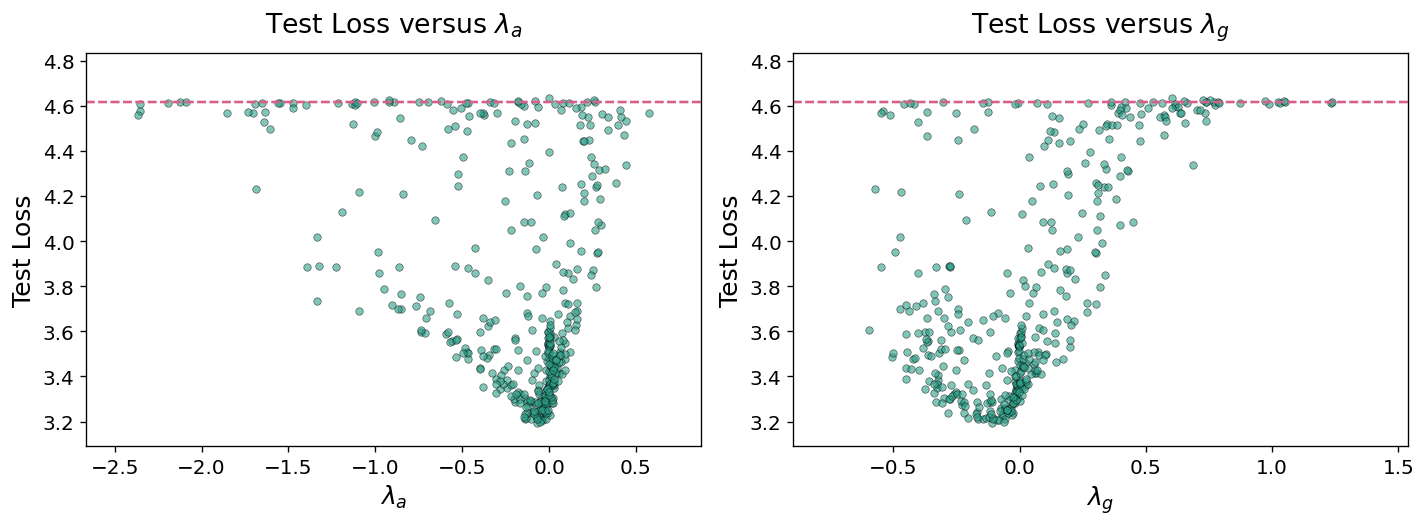

In [23]:
##### plot test loss vs lambda_a / lambda_g scatters
# ── 1. load data ─────────────────────────────────────────────
la  = np.load('grid/lambda_a_grid.npz')['data'].ravel()
lg  = np.load('grid/lambda_g_grid.npz')['data'].ravel()
tl = np.load('grid/testloss_grid.npz')['data'].ravel()
tli = np.load('grid/testloss_init_grid.npz')['data'].ravel()

# ── 2. plot ──────────────────────────────────────────────────────────
# plt.figure(figsize=(6, 4.5), dpi=120)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5), dpi=120)

# main scatter
scatter_kw = dict(
    s=20,              # 30-pt marker in area units
    lw=0.4, edgecolor='k',
    alpha=0.6, facecolor='#2CA089'
)

ax1.scatter(la, tl, **scatter_kw)
ax2.scatter(lg, tl, **scatter_kw)

# baseline dashed line (top of the cloud)
y_ref = math.log(101)          # or any constant you wish
ax1.axhline(y_ref, ls='--', lw=1.4, color='#D95F8B')
ax2.axhline(y_ref, ls='--', lw=1.4, color='#D95F8B')

# ── cosmetics ─────────────────────────────────────────────────────────
for ax in (ax1, ax2):
    ax.axhline(y_ref, ls='--', lw=1.4, color='#D95F8B')
    ax.set_ylim(tl.min() - .1, tl.max() + .2)
    ax.tick_params(labelsize=12)

ax1.set_xlabel(r'$\lambda_a$', fontsize=15)
ax1.set_ylabel(r'Test Loss',   fontsize=15)
ax1.set_title(r'Test Loss versus $\lambda_a$', fontsize=16, pad=12)
ax1.set_xlim(la.min() - .3, la.max() + .3)

ax2.set_xlabel(r'$\lambda_g$', fontsize=15)
ax2.set_ylabel(r'Test Loss',   fontsize=15)
ax2.set_title(r'Test Loss versus $\lambda_g$', fontsize=16, pad=12)
ax2.set_xlim(lg.min() - .3, lg.max() + .3)

fig.tight_layout()

plt.show()

fig.savefig(f"testloss_vs_lambda_sA{sigma_A:.1f}.pdf", format="pdf")   # or give a full path

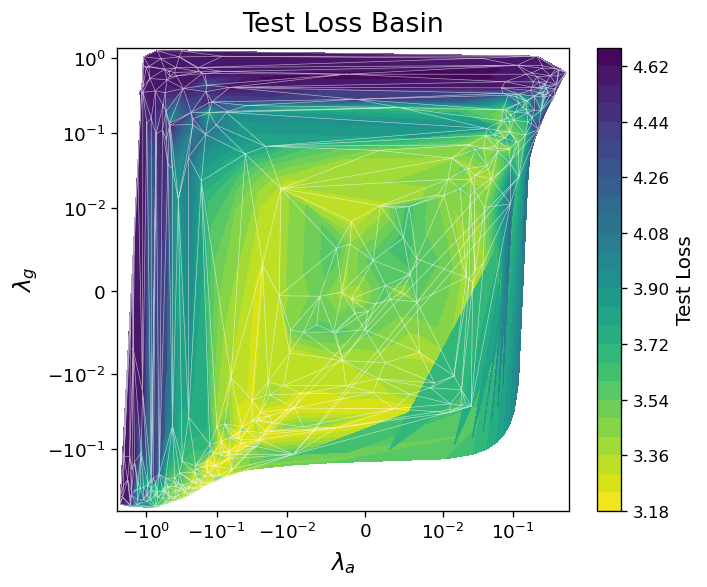

In [35]:
import matplotlib.tri as mtri

# ── 1. load your 1-D data vectors ────────────────────────────────────
la = np.load('grid/lambda_a_grid.npz')['data'].ravel()      # λ_a
lg = np.load('grid/lambda_g_grid.npz')['data'].ravel()      # λ_g
tl = np.load('grid/testloss_grid.npz')['data'].ravel()      # test loss

# ── 2. triangulation (Delaunay in 2-D) ───────────────────────────────
tri = mtri.Triangulation(la, lg)

# ── 3. plot ──────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6, 5), dpi=120)

# filled contour (25 levels by default)
cntr = ax.tricontourf(tri, tl, levels=25, cmap='viridis_r')

# white wire-frame overlay
ax.triplot(tri, lw=0.4, color='white', alpha=0.6)

# colour-bar
cbar = fig.colorbar(cntr, ax=ax)
cbar.set_label(r'Test Loss', fontsize=12)

# ── 4. cosmetics & log axes ─────────────────────────────────────────
ax.set_xlabel(r'$\lambda_a$', fontsize=14)
ax.set_ylabel(r'$\lambda_g$', fontsize=14)
ax.set_title(r'Test Loss Basin', fontsize=16, pad=10)

# symmetric-log so negative & positive region both stretch
ax.set_xscale('symlog', linthresh=1e-2)
ax.set_yscale('symlog', linthresh=1e-2)

ax.tick_params(labelsize=11)
ax.set_xlim(la.min()*1.1, la.max()*1.1)
ax.set_ylim(lg.min()*1.1, lg.max()*1.1)

plt.tight_layout()
plt.show()

fig.savefig(f"testloss_basin_sA{sigma_A:.1f}.pdf", format="pdf")   # or give a full path